## Стрижов Григорий - CS

Обучающая выборка состоит из изображений и 5-7 эквивалентных способов текстового описания для каждого изображения.

Для тестовых изображений необходимо вывести текстовое описание.

Модель состоит из свёрточной нейронной сети энкодера и рекуррентной нейронной сети декодера. Энкодер превращает изображения в векторный вид, декодер выписывает последовательность слов.

В качестве энкодера я взял предобученную сеть GoogleNet. Сеть обучалась для классификации большого количества изображений (не из моей обучающей выборки), я отрезал от неё последний слой, а выход предпоследего взял в качестве векторного представления для входного изображения.

В качестве декодера я использовал рекуррентную LSTM сеть, скрытым состоянием которой является векторизованная картинка вышеописанным образом. Рекуррентная сеть последовательно будет выписывать слова по вероятностям, имея на каждом шаге выписывания - скрытое состояние в виде картинки и уже выписанные слова.

Для тестирования я использовал случайно найденные в google картинки. Внизу ноутбука представлены удачные и ошибочные срабатывания.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
###
### Or alternatevely
### !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
### !tar -xvzf data.tar.gz
###

DATA_DIR = './'

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import os.path as osp
import pickle

img_codes = np.load(osp.join(DATA_DIR, "data/image_codes.npy"))
captions = pickle.load(open(osp.join(DATA_DIR, 'data/caption_tokens.pcl'), 'rb'))

CPU times: user 1.63 s, sys: 444 ms, total: 2.08 s
Wall time: 1.73 s


In [3]:
print ("each image code is a 1000-unit vector:", img_codes.shape)
print (img_codes[0,:10])
print ('\n\n')
print ("for each image there are 5-7 descriptions, e.g.:\n")
print ('\n'.join(captions[0]))

('each image code is a 1000-unit vector:', (123287, 1000))
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


In [5]:
captions[0][0]

['#START#',
 u'a',
 u'man',
 u'with',
 u'a',
 u'red',
 u'helmet',
 u'on',
 u'a',
 u'small',
 u'moped',
 u'on',
 u'a',
 u'dirt',
 u'road',
 '#END#']

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for group in captions:
    for caption in group:
        word_counts.update(caption)

In [7]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


### Neural Network

In [10]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 256
LSTM_UNITS = 1000

In [11]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 85.0% of memory, cuDNN 5105)


In [12]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [13]:
import lasagne
from lasagne.layers import *

In [14]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask )

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [15]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors )

dropout = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(dropout, LSTM_UNITS)

assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [16]:
decoder = LSTMLayer(
    l_word_embeddings, 
    LSTM_UNITS, 
    cell_init=l_image_features_small,
    grad_clipping=10,
    mask_input=l_mask)

#a recurrent layer (gru/lstm)

In [17]:
#!pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [18]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

broadcasted decoder shape =  (None, 1000)


In [19]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,
                                              n_tokens,
                                              nonlinearity=T.nnet.softmax)

In [20]:
predicted_probabilities_each_tick.output_shape

(None, 10373)

In [21]:
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print "output shape = ",predicted_probabilities.output_shape

assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


In [22]:
next_word_probas = get_output(predicted_probabilities)


predictions_flat = next_word_probas[:,:-1].reshape((-1,n_tokens))
reference_answers = sentences[:,1:].reshape((-1,))

loss = lasagne.objectives.categorical_crossentropy(predictions_flat,
                                                  reference_answers)

output_mask = sentence_mask[:,1:]
loss = loss.mean()

In [23]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=0.0001)

In [24]:
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

# Training

In [25]:
captions = np.array(captions)

In [26]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    batch_images = images[random_image_ix]
    
    captions_for_batch_images = captions[random_image_ix]
    
    batch_captions = map(choice,captions_for_batch_images)
    
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix
    

In [27]:
generate_batch(img_codes,captions,3)

(array([[-1.574543  , -2.15094423,  0.27671677, ..., -2.88713455,
          0.67758632, -0.33253634],
        [-3.49236965, -1.84117079,  0.92057592, ..., -1.23948491,
          2.25305605, -2.09316969],
        [-1.59219289,  2.42629981, -2.10849142, ...,  6.33236217,
          4.19294739,  2.62268925]], dtype=float32),
 array([[ 8481,  8717,  8353,   326,  8717,  9834, 10058,  1431,  8902,
          8330,   781,  2853,  3260,  7579,   781,  8717,  8353,  8134],
        [ 8481,  8717,   706, 10114,  1604,  8848,   781,   706,   957,
          8134,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1],
        [ 8481,  8717, 10014,  3974,   352,  4859, 10157,  2212, 10058,
          5155,  1260,  8134,    -1,    -1,    -1,    -1,    -1,    -1]], dtype=int32))

### Main loop of training

In [28]:
batch_size=10
n_epochs=1000
n_batches_per_epoch = 100
n_validation_batches = 7 #how many batches are used for validation after each epoch


In [29]:
#!pip3 install --user tqdm

In [30]:
from tqdm import tqdm

max_val_loss = 100500

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    if val_loss < max_val_loss:
        max_val_loss = val_loss
        best_params = get_all_param_values(predicted_probabilities)
        print("New best val_acc {} %\n".format(max_val_loss))

print("Finish :)")

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.2561238873, val loss: 3.37078598567
New best val_acc 3.37078598567 %



  1%|          | 1/100 [00:00<00:11,  8.39it/s]


Epoch: 1, train loss: 3.18135685325, val loss: 3.17741537094
New best val_acc 3.17741537094 %



  2%|▏         | 2/100 [00:00<00:09, 10.61it/s]


Epoch: 2, train loss: 3.07638841987, val loss: 3.15322688648
New best val_acc 3.15322688648 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 3, train loss: 2.93698392749, val loss: 2.70607461248
New best val_acc 2.70607461248 %



  2%|▏         | 2/100 [00:00<00:08, 10.99it/s]


Epoch: 4, train loss: 2.67166169047, val loss: 2.78519157001


  2%|▏         | 2/100 [00:00<00:09, 10.87it/s]


Epoch: 5, train loss: 2.66911129117, val loss: 2.10662400723
New best val_acc 2.10662400723 %



  2%|▏         | 2/100 [00:00<00:09,  9.87it/s]


Epoch: 6, train loss: 2.54441595435, val loss: 2.40996277332


  2%|▏         | 2/100 [00:00<00:09, 10.65it/s]


Epoch: 7, train loss: 2.44193063021, val loss: 2.52354969297


  1%|          | 1/100 [00:00<00:11,  8.97it/s]


Epoch: 8, train loss: 2.27475670099, val loss: 2.31245398521


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 9, train loss: 2.19833234072, val loss: 2.42057078225


  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 10, train loss: 2.12684517026, val loss: 2.17720854282


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]


Epoch: 11, train loss: 2.15163677454, val loss: 2.4711364678


  1%|          | 1/100 [00:00<00:14,  7.03it/s]


Epoch: 12, train loss: 2.1577378726, val loss: 2.14154297965


  1%|          | 1/100 [00:00<00:12,  8.10it/s]


Epoch: 13, train loss: 2.04733409762, val loss: 2.21409135205


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 14, train loss: 2.04929142118, val loss: 2.04185034548
New best val_acc 2.04185034548 %



  1%|          | 1/100 [00:00<00:10,  9.51it/s]


Epoch: 15, train loss: 2.07090963185, val loss: 1.91566494533
New best val_acc 1.91566494533 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 16, train loss: 1.99577066779, val loss: 1.84698496546
New best val_acc 1.84698496546 %



  1%|          | 1/100 [00:00<00:11,  8.94it/s]


Epoch: 17, train loss: 1.94205842018, val loss: 1.98858426298


  1%|          | 1/100 [00:00<00:10,  9.17it/s]


Epoch: 18, train loss: 2.00294986248, val loss: 2.07193638597


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 19, train loss: 1.91673818231, val loss: 2.10853539194


  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]


Epoch: 20, train loss: 1.90008780241, val loss: 1.8236287662
New best val_acc 1.8236287662 %



  1%|          | 1/100 [00:00<00:16,  6.03it/s]


Epoch: 21, train loss: 1.91155339539, val loss: 1.75772654159
New best val_acc 1.75772654159 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 22, train loss: 1.89375818253, val loss: 1.77583146095


  2%|▏         | 2/100 [00:00<00:10,  9.78it/s]


Epoch: 23, train loss: 1.96111994147, val loss: 1.85455402306


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 24, train loss: 1.82186706424, val loss: 1.89511169706


  1%|          | 1/100 [00:00<00:13,  7.07it/s]


Epoch: 25, train loss: 1.86399009526, val loss: 2.04186539991


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 26, train loss: 1.81923723161, val loss: 1.74456245559
New best val_acc 1.74456245559 %



  1%|          | 1/100 [00:00<00:12,  8.08it/s]


Epoch: 27, train loss: 1.8569694823, val loss: 1.76956047331


  1%|          | 1/100 [00:00<00:13,  7.55it/s]


Epoch: 28, train loss: 1.79372073054, val loss: 1.90082010201


  1%|          | 1/100 [00:00<00:11,  8.96it/s]


Epoch: 29, train loss: 1.80068258286, val loss: 1.74245444366
New best val_acc 1.74245444366 %



  1%|          | 1/100 [00:00<00:11,  8.56it/s]


Epoch: 30, train loss: 1.80452655077, val loss: 1.88941209657


  1%|          | 1/100 [00:00<00:13,  7.58it/s]


Epoch: 31, train loss: 1.77576276124, val loss: 1.85351547173


  2%|▏         | 2/100 [00:00<00:08, 11.67it/s]


Epoch: 32, train loss: 1.79013658941, val loss: 1.8273130485


  1%|          | 1/100 [00:00<00:11,  8.99it/s]


Epoch: 33, train loss: 1.76106846154, val loss: 1.68732609068
New best val_acc 1.68732609068 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 34, train loss: 1.82006028652, val loss: 1.62999338763
New best val_acc 1.62999338763 %



  2%|▏         | 2/100 [00:00<00:09, 10.66it/s]


Epoch: 35, train loss: 1.75838564575, val loss: 1.68835582052


  1%|          | 1/100 [00:00<00:10,  9.90it/s]


Epoch: 36, train loss: 1.72215394974, val loss: 1.8435002906


  1%|          | 1/100 [00:00<00:11,  8.88it/s]


Epoch: 37, train loss: 1.71631033719, val loss: 1.96289115293


  2%|▏         | 2/100 [00:00<00:09, 10.61it/s]


Epoch: 38, train loss: 1.67098602951, val loss: 1.81441031184


  1%|          | 1/100 [00:00<00:10,  9.23it/s]


Epoch: 39, train loss: 1.71692701757, val loss: 1.82796721799


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 40, train loss: 1.73997883856, val loss: 1.85337078571


  1%|          | 1/100 [00:00<00:10,  9.27it/s]


Epoch: 41, train loss: 1.67787192404, val loss: 1.72063214438


  2%|▏         | 2/100 [00:00<00:09, 10.15it/s]


Epoch: 42, train loss: 1.7257857722, val loss: 1.75423393931


  2%|▏         | 2/100 [00:00<00:08, 11.53it/s]


Epoch: 43, train loss: 1.67652535617, val loss: 1.60048978669
New best val_acc 1.60048978669 %



  2%|▏         | 2/100 [00:00<00:07, 12.31it/s]


Epoch: 44, train loss: 1.6786609894, val loss: 1.66168948582


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 45, train loss: 1.6753004241, val loss: 1.84597209522


  1%|          | 1/100 [00:00<00:15,  6.29it/s]


Epoch: 46, train loss: 1.73628591299, val loss: 1.59833357164
New best val_acc 1.59833357164 %



  2%|▏         | 2/100 [00:00<00:09, 10.34it/s]


Epoch: 47, train loss: 1.75021269321, val loss: 1.70249675001


  2%|▏         | 2/100 [00:00<00:09, 10.55it/s]


Epoch: 48, train loss: 1.68167063355, val loss: 1.74856737682


  1%|          | 1/100 [00:00<00:09,  9.95it/s]


Epoch: 49, train loss: 1.66969753206, val loss: 1.59071379048
New best val_acc 1.59071379048 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 50, train loss: 1.73808776736, val loss: 1.6171164172


  1%|          | 1/100 [00:00<00:11,  8.27it/s]


Epoch: 51, train loss: 1.64220782876, val loss: 1.76827839443


  1%|          | 1/100 [00:00<00:10,  9.81it/s]


Epoch: 52, train loss: 1.66233616054, val loss: 1.77751694407


  1%|          | 1/100 [00:00<00:11,  8.83it/s]


Epoch: 53, train loss: 1.62227058947, val loss: 1.67718127796


  1%|          | 1/100 [00:00<00:09,  9.91it/s]


Epoch: 54, train loss: 1.62956903338, val loss: 1.53138223716
New best val_acc 1.53138223716 %



  1%|          | 1/100 [00:00<00:11,  8.68it/s]


Epoch: 55, train loss: 1.68275335491, val loss: 1.80671257632


  2%|▏         | 2/100 [00:00<00:09, 10.08it/s]


Epoch: 56, train loss: 1.66884219527, val loss: 1.70995863846


  2%|▏         | 2/100 [00:00<00:09, 10.89it/s]


Epoch: 57, train loss: 1.6705185622, val loss: 1.68327094827


  2%|▏         | 2/100 [00:00<00:09, 10.29it/s]


Epoch: 58, train loss: 1.66773923695, val loss: 1.65916159323


  2%|▏         | 2/100 [00:00<00:09, 10.46it/s]


Epoch: 59, train loss: 1.56169166088, val loss: 1.72922623158


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 60, train loss: 1.62344604731, val loss: 1.44771863733
New best val_acc 1.44771863733 %



  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]


Epoch: 61, train loss: 1.58935556233, val loss: 1.85557038443


  2%|▏         | 2/100 [00:00<00:07, 13.37it/s]


Epoch: 62, train loss: 1.64204248905, val loss: 1.73671260902


  1%|          | 1/100 [00:00<00:11,  8.39it/s]


Epoch: 63, train loss: 1.61301631153, val loss: 1.61338743142


  1%|          | 1/100 [00:00<00:11,  8.63it/s]


Epoch: 64, train loss: 1.58401819944, val loss: 1.53296676704


  2%|▏         | 2/100 [00:00<00:09,  9.90it/s]


Epoch: 65, train loss: 1.66030444622, val loss: 1.63327804634


  1%|          | 1/100 [00:00<00:14,  6.76it/s]


Epoch: 66, train loss: 1.62259094894, val loss: 1.67338451317


  1%|          | 1/100 [00:00<00:11,  8.73it/s]


Epoch: 67, train loss: 1.58820544243, val loss: 1.49420227323


  2%|▏         | 2/100 [00:00<00:08, 10.90it/s]


Epoch: 68, train loss: 1.61794970751, val loss: 1.72058859893


  1%|          | 1/100 [00:00<00:11,  8.57it/s]


Epoch: 69, train loss: 1.59778969407, val loss: 1.29178678138
New best val_acc 1.29178678138 %



  2%|▏         | 2/100 [00:00<00:08, 11.76it/s]


Epoch: 70, train loss: 1.58515237033, val loss: 1.65747443267


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]


Epoch: 71, train loss: 1.57524761736, val loss: 1.68674971376


  1%|          | 1/100 [00:00<00:10,  9.60it/s]


Epoch: 72, train loss: 1.56738848209, val loss: 1.73895888669


  1%|          | 1/100 [00:00<00:12,  7.91it/s]


Epoch: 73, train loss: 1.61886979043, val loss: 1.58964531762


  1%|          | 1/100 [00:00<00:19,  5.20it/s]


Epoch: 74, train loss: 1.57037501037, val loss: 1.53616094589


  2%|▏         | 2/100 [00:00<00:08, 11.65it/s]


Epoch: 75, train loss: 1.560644297, val loss: 1.5909902198


  1%|          | 1/100 [00:00<00:10,  9.80it/s]


Epoch: 76, train loss: 1.5356903851, val loss: 1.62943967751


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 77, train loss: 1.60049763322, val loss: 1.44072193759


  2%|▏         | 2/100 [00:00<00:08, 11.43it/s]


Epoch: 78, train loss: 1.59136758745, val loss: 1.56763146605


  1%|          | 1/100 [00:00<00:10,  9.73it/s]


Epoch: 79, train loss: 1.51116257727, val loss: 1.48292338848


  2%|▏         | 2/100 [00:00<00:07, 12.53it/s]


Epoch: 80, train loss: 1.5893486011, val loss: 1.44102706228


  2%|▏         | 2/100 [00:00<00:08, 11.30it/s]


Epoch: 81, train loss: 1.59235712051, val loss: 1.67552820274


  2%|▏         | 2/100 [00:00<00:09,  9.96it/s]


Epoch: 82, train loss: 1.55579006493, val loss: 1.62979946818


  1%|          | 1/100 [00:00<00:14,  6.87it/s]


Epoch: 83, train loss: 1.54386416852, val loss: 1.49047794512


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 84, train loss: 1.61469742656, val loss: 1.62141319684


  1%|          | 1/100 [00:00<00:10,  9.34it/s]


Epoch: 85, train loss: 1.54826848626, val loss: 1.59136715957


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 86, train loss: 1.52227706432, val loss: 1.74138520445


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 87, train loss: 1.53644086182, val loss: 1.6106265613


  2%|▏         | 2/100 [00:00<00:08, 12.11it/s]


Epoch: 88, train loss: 1.51356568515, val loss: 1.5966729096


  1%|          | 1/100 [00:00<00:11,  8.92it/s]


Epoch: 89, train loss: 1.5304067409, val loss: 1.7368075507


  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]


Epoch: 90, train loss: 1.53513031602, val loss: 1.57770746095


  2%|▏         | 2/100 [00:00<00:08, 10.98it/s]


Epoch: 91, train loss: 1.58891804636, val loss: 1.57174759252


  2%|▏         | 2/100 [00:00<00:08, 11.91it/s]


Epoch: 92, train loss: 1.53229439676, val loss: 1.65271236215


  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 93, train loss: 1.56661462665, val loss: 1.4947093044


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 94, train loss: 1.5288407445, val loss: 1.44506680965


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 95, train loss: 1.50613497138, val loss: 1.47292568002


  1%|          | 1/100 [00:00<00:10,  9.81it/s]


Epoch: 96, train loss: 1.48399202526, val loss: 1.58034118584


  1%|          | 1/100 [00:00<00:11,  8.56it/s]


Epoch: 97, train loss: 1.50750944674, val loss: 1.49146085126


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 98, train loss: 1.46970812917, val loss: 1.47772162301


  2%|▏         | 2/100 [00:00<00:08, 11.13it/s]


Epoch: 99, train loss: 1.51394953191, val loss: 1.44060542754


  2%|▏         | 2/100 [00:00<00:09, 10.50it/s]


Epoch: 100, train loss: 1.52640468717, val loss: 1.42724679198


  1%|          | 1/100 [00:00<00:12,  7.77it/s]


Epoch: 101, train loss: 1.52168882549, val loss: 1.61107070105


  1%|          | 1/100 [00:00<00:11,  8.93it/s]


Epoch: 102, train loss: 1.50348806977, val loss: 1.69732516153


  2%|▏         | 2/100 [00:00<00:09, 10.49it/s]


Epoch: 103, train loss: 1.55409113467, val loss: 1.61323700632


  1%|          | 1/100 [00:00<00:12,  7.89it/s]


Epoch: 104, train loss: 1.54208508193, val loss: 1.55027335031


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 105, train loss: 1.52743917108, val loss: 1.42709927899


  2%|▏         | 2/100 [00:00<00:09, 10.51it/s]


Epoch: 106, train loss: 1.50198409557, val loss: 1.50344576154


  2%|▏         | 2/100 [00:00<00:09, 10.31it/s]


Epoch: 107, train loss: 1.49739219368, val loss: 1.59945298944


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 108, train loss: 1.51427634001, val loss: 1.54139253071


  1%|          | 1/100 [00:00<00:10,  9.90it/s]


Epoch: 109, train loss: 1.54788893461, val loss: 1.44534398828


  2%|▏         | 2/100 [00:00<00:09, 10.14it/s]


Epoch: 110, train loss: 1.50333653331, val loss: 1.70716410024


  2%|▏         | 2/100 [00:00<00:09,  9.81it/s]


Epoch: 111, train loss: 1.4589800185, val loss: 1.69470477104


  2%|▏         | 2/100 [00:00<00:09, 10.06it/s]


Epoch: 112, train loss: 1.45963045478, val loss: 1.4151600429


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 113, train loss: 1.53852417111, val loss: 1.48137543883


  2%|▏         | 2/100 [00:00<00:08, 11.47it/s]


Epoch: 114, train loss: 1.51667968214, val loss: 1.50677679266


  1%|          | 1/100 [00:00<00:10,  9.07it/s]


Epoch: 115, train loss: 1.45941704988, val loss: 1.5379651274


  2%|▏         | 2/100 [00:00<00:08, 11.27it/s]


Epoch: 116, train loss: 1.45793047607, val loss: 1.60906066213


  2%|▏         | 2/100 [00:00<00:08, 11.28it/s]


Epoch: 117, train loss: 1.48979603171, val loss: 1.57618553298


  2%|▏         | 2/100 [00:00<00:08, 11.44it/s]


Epoch: 118, train loss: 1.49352750897, val loss: 1.57691008704


  2%|▏         | 2/100 [00:00<00:08, 11.74it/s]


Epoch: 119, train loss: 1.54016982019, val loss: 1.54083148071


  2%|▏         | 2/100 [00:00<00:09, 10.10it/s]


Epoch: 120, train loss: 1.50887821913, val loss: 1.60595508984


  1%|          | 1/100 [00:00<00:11,  8.91it/s]


Epoch: 121, train loss: 1.46987914741, val loss: 1.48462808132


  2%|▏         | 2/100 [00:00<00:09, 10.52it/s]


Epoch: 122, train loss: 1.41750059783, val loss: 1.4845563003


  2%|▏         | 2/100 [00:00<00:07, 12.40it/s]


Epoch: 123, train loss: 1.46681573212, val loss: 1.43436253922


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 124, train loss: 1.4982264328, val loss: 1.48853487628


  1%|          | 1/100 [00:00<00:10,  9.63it/s]


Epoch: 125, train loss: 1.48858645737, val loss: 1.58816758224


  1%|          | 1/100 [00:00<00:11,  8.90it/s]


Epoch: 126, train loss: 1.43826895893, val loss: 1.31433951855


  1%|          | 1/100 [00:00<00:11,  8.41it/s]


Epoch: 127, train loss: 1.45138930023, val loss: 1.55285642828


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 128, train loss: 1.47042143106, val loss: 1.56047763143


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 129, train loss: 1.50659665763, val loss: 1.43416358743


  2%|▏         | 2/100 [00:00<00:08, 11.95it/s]


Epoch: 130, train loss: 1.47753863811, val loss: 1.45507861887


  1%|          | 1/100 [00:00<00:09,  9.95it/s]


Epoch: 131, train loss: 1.45503717244, val loss: 1.41036656925


  1%|          | 1/100 [00:00<00:09, 10.00it/s]


Epoch: 132, train loss: 1.45390215456, val loss: 1.57469568934


  2%|▏         | 2/100 [00:00<00:09, 10.11it/s]


Epoch: 133, train loss: 1.4294944495, val loss: 1.44156558173


  1%|          | 1/100 [00:00<00:10,  9.23it/s]


Epoch: 134, train loss: 1.47134647369, val loss: 1.36489183562


  2%|▏         | 2/100 [00:00<00:09, 10.00it/s]


Epoch: 135, train loss: 1.46001424491, val loss: 1.41918279443


  1%|          | 1/100 [00:00<00:11,  8.67it/s]


Epoch: 136, train loss: 1.45359930515, val loss: 1.44622589861


  1%|          | 1/100 [00:00<00:10,  9.64it/s]


Epoch: 137, train loss: 1.49169147313, val loss: 1.51641350133


  1%|          | 1/100 [00:00<00:12,  8.14it/s]


Epoch: 138, train loss: 1.47537439525, val loss: 1.45079452651


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 139, train loss: 1.45195383549, val loss: 1.53122149195


  1%|          | 1/100 [00:00<00:13,  7.12it/s]


Epoch: 140, train loss: 1.49728214324, val loss: 1.56125101021


  1%|          | 1/100 [00:00<00:10,  9.84it/s]


Epoch: 141, train loss: 1.42636027753, val loss: 1.48434713909


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 142, train loss: 1.48005558729, val loss: 1.4695006609


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 143, train loss: 1.46099399149, val loss: 1.42323315144


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 144, train loss: 1.45694149673, val loss: 1.37670006071


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 145, train loss: 1.43998247862, val loss: 1.28710871935
New best val_acc 1.28710871935 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 146, train loss: 1.43585868359, val loss: 1.44992121628


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 147, train loss: 1.45679749072, val loss: 1.39495156493


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 148, train loss: 1.46327535152, val loss: 1.35965579748


  1%|          | 1/100 [00:00<00:11,  8.46it/s]


Epoch: 149, train loss: 1.44477884114, val loss: 1.50022837094


  1%|          | 1/100 [00:00<00:17,  5.75it/s]


Epoch: 150, train loss: 1.47227283239, val loss: 1.51464927197


  2%|▏         | 2/100 [00:00<00:08, 11.87it/s]


Epoch: 151, train loss: 1.43353091776, val loss: 1.42541064535


  1%|          | 1/100 [00:00<00:11,  8.42it/s]


Epoch: 152, train loss: 1.42596580327, val loss: 1.45455124549


  2%|▏         | 2/100 [00:00<00:07, 12.41it/s]


Epoch: 153, train loss: 1.43839634776, val loss: 1.49801249163


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 154, train loss: 1.41195323586, val loss: 1.3821829898


  2%|▏         | 2/100 [00:00<00:08, 11.29it/s]


Epoch: 155, train loss: 1.4345501107, val loss: 1.45746136563


  2%|▏         | 2/100 [00:00<00:09, 10.62it/s]


Epoch: 156, train loss: 1.47692848265, val loss: 1.52818293231


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 157, train loss: 1.44523418665, val loss: 1.37947590011


  1%|          | 1/100 [00:00<00:09,  9.97it/s]


Epoch: 158, train loss: 1.40851124465, val loss: 1.47388606412


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]


Epoch: 159, train loss: 1.44734656394, val loss: 1.5182671036


  2%|▏         | 2/100 [00:00<00:09, 10.83it/s]


Epoch: 160, train loss: 1.41667493582, val loss: 1.53938102722


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 161, train loss: 1.41754837096, val loss: 1.54400357178


  1%|          | 1/100 [00:00<00:13,  7.24it/s]


Epoch: 162, train loss: 1.47832000673, val loss: 1.44647732803


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 163, train loss: 1.3944835794, val loss: 1.64050413881


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 164, train loss: 1.40179580331, val loss: 1.2653688533
New best val_acc 1.2653688533 %



  2%|▏         | 2/100 [00:00<00:08, 12.16it/s]


Epoch: 165, train loss: 1.44025497019, val loss: 1.39237478801


  1%|          | 1/100 [00:00<00:11,  8.30it/s]


Epoch: 166, train loss: 1.41037495971, val loss: 1.34216507844


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 167, train loss: 1.42350072443, val loss: 1.32572607483


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]


Epoch: 168, train loss: 1.45739348292, val loss: 1.42765656539


  1%|          | 1/100 [00:00<00:10,  9.21it/s]


Epoch: 169, train loss: 1.46234232724, val loss: 1.29609872614


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 170, train loss: 1.43964705408, val loss: 1.41467869282


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 171, train loss: 1.43169375956, val loss: 1.46285705907


  2%|▏         | 2/100 [00:00<00:09, 10.44it/s]


Epoch: 172, train loss: 1.47423314691, val loss: 1.38571550165


  1%|          | 1/100 [00:00<00:10,  9.42it/s]


Epoch: 173, train loss: 1.42405030787, val loss: 1.42508096354


  2%|▏         | 2/100 [00:00<00:08, 11.59it/s]


Epoch: 174, train loss: 1.43883525908, val loss: 1.40388190746


  1%|          | 1/100 [00:00<00:10,  9.01it/s]


Epoch: 175, train loss: 1.43757578015, val loss: 1.54013671194


  1%|          | 1/100 [00:00<00:10,  9.31it/s]


Epoch: 176, train loss: 1.40259663284, val loss: 1.41633985724


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]


Epoch: 177, train loss: 1.40956377625, val loss: 1.53229335376


  2%|▏         | 2/100 [00:00<00:09, 10.81it/s]


Epoch: 178, train loss: 1.42805608392, val loss: 1.43315141542


  2%|▏         | 2/100 [00:00<00:08, 10.95it/s]


Epoch: 179, train loss: 1.42557846546, val loss: 1.29946276971


  2%|▏         | 2/100 [00:00<00:08, 10.93it/s]


Epoch: 180, train loss: 1.41425894022, val loss: 1.39522844553


  2%|▏         | 2/100 [00:00<00:08, 12.25it/s]


Epoch: 181, train loss: 1.38264898419, val loss: 1.3790974617


  1%|          | 1/100 [00:00<00:10,  9.72it/s]


Epoch: 182, train loss: 1.42032387972, val loss: 1.40337173428


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]


Epoch: 183, train loss: 1.42285323739, val loss: 1.44991544315


  2%|▏         | 2/100 [00:00<00:09, 10.74it/s]


Epoch: 184, train loss: 1.42890704095, val loss: 1.51570154939


  2%|▏         | 2/100 [00:00<00:08, 11.33it/s]


Epoch: 185, train loss: 1.39086643279, val loss: 1.70961425986


  1%|          | 1/100 [00:00<00:10,  9.33it/s]


Epoch: 186, train loss: 1.46446454525, val loss: 1.3128308739


  2%|▏         | 2/100 [00:00<00:09, 10.68it/s]


Epoch: 187, train loss: 1.39079186559, val loss: 1.3053638339


  2%|▏         | 2/100 [00:00<00:09,  9.88it/s]


Epoch: 188, train loss: 1.38159779787, val loss: 1.35507348606


  2%|▏         | 2/100 [00:00<00:08, 11.68it/s]


Epoch: 189, train loss: 1.41331843376, val loss: 1.36017986706


  2%|▏         | 2/100 [00:00<00:08, 11.00it/s]


Epoch: 190, train loss: 1.42841019094, val loss: 1.41383564472


  2%|▏         | 2/100 [00:00<00:09, 10.59it/s]


Epoch: 191, train loss: 1.40200936794, val loss: 1.35225058453


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 192, train loss: 1.39836140633, val loss: 1.45818788665


  1%|          | 1/100 [00:00<00:11,  8.77it/s]


Epoch: 193, train loss: 1.44624694526, val loss: 1.38727836949


  2%|▏         | 2/100 [00:00<00:09,  9.97it/s]


Epoch: 194, train loss: 1.3531519568, val loss: 1.40117922851


  1%|          | 1/100 [00:00<00:10,  9.28it/s]


Epoch: 195, train loss: 1.38429379523, val loss: 1.42422722919


  2%|▏         | 2/100 [00:00<00:09, 10.46it/s]


Epoch: 196, train loss: 1.39258643508, val loss: 1.45385910783


  2%|▏         | 2/100 [00:00<00:08, 11.92it/s]


Epoch: 197, train loss: 1.40890295804, val loss: 1.55749164309


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 198, train loss: 1.39192390144, val loss: 1.49968668393


  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]


Epoch: 199, train loss: 1.39400668204, val loss: 1.50726442678


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]


Epoch: 200, train loss: 1.39578842819, val loss: 1.46728343623


  2%|▏         | 2/100 [00:00<00:08, 11.81it/s]


Epoch: 201, train loss: 1.42165000916, val loss: 1.23514064721
New best val_acc 1.23514064721 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 202, train loss: 1.38454659641, val loss: 1.31878861359


  1%|          | 1/100 [00:00<00:12,  8.24it/s]


Epoch: 203, train loss: 1.36857208133, val loss: 1.32643145323


  1%|          | 1/100 [00:00<00:10,  9.06it/s]


Epoch: 204, train loss: 1.40832463622, val loss: 1.41662274088


  2%|▏         | 2/100 [00:00<00:09, 10.27it/s]


Epoch: 205, train loss: 1.35657713473, val loss: 1.48376015254


  2%|▏         | 2/100 [00:00<00:07, 13.24it/s]


Epoch: 206, train loss: 1.37673893452, val loss: 1.44103823389


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 207, train loss: 1.38762484431, val loss: 1.27409903492


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 208, train loss: 1.37336357176, val loss: 1.55310143743


  2%|▏         | 2/100 [00:00<00:09, 10.23it/s]


Epoch: 209, train loss: 1.38246178508, val loss: 1.40026438236


  1%|          | 1/100 [00:00<00:10,  9.15it/s]


Epoch: 210, train loss: 1.3746200645, val loss: 1.33211354698


  2%|▏         | 2/100 [00:00<00:09,  9.99it/s]


Epoch: 211, train loss: 1.38992802024, val loss: 1.39460548333


  2%|▏         | 2/100 [00:00<00:08, 11.06it/s]


Epoch: 212, train loss: 1.3703031987, val loss: 1.36115415607


  2%|▏         | 2/100 [00:00<00:09, 10.43it/s]


Epoch: 213, train loss: 1.41388787806, val loss: 1.33215309892


  2%|▏         | 2/100 [00:00<00:08, 11.25it/s]


Epoch: 214, train loss: 1.4133941263, val loss: 1.47034273829


  2%|▏         | 2/100 [00:00<00:09,  9.87it/s]


Epoch: 215, train loss: 1.38000399888, val loss: 1.24031536068


  2%|▏         | 2/100 [00:00<00:09, 10.08it/s]


Epoch: 216, train loss: 1.41692803383, val loss: 1.36818046229


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]


Epoch: 217, train loss: 1.36014665723, val loss: 1.3466416938


  1%|          | 1/100 [00:00<00:15,  6.47it/s]


Epoch: 218, train loss: 1.36451122761, val loss: 1.30496173246


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 219, train loss: 1.33717232227, val loss: 1.43060496024


  2%|▏         | 2/100 [00:00<00:09, 10.44it/s]


Epoch: 220, train loss: 1.3565572077, val loss: 1.56181957892


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 221, train loss: 1.38735692918, val loss: 1.41058267014


  1%|          | 1/100 [00:00<00:12,  7.75it/s]


Epoch: 222, train loss: 1.39611011684, val loss: 1.42071441242


  2%|▏         | 2/100 [00:00<00:08, 11.63it/s]


Epoch: 223, train loss: 1.35069137692, val loss: 1.34399692501


  2%|▏         | 2/100 [00:00<00:08, 12.01it/s]


Epoch: 224, train loss: 1.39772891462, val loss: 1.38841516631


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]


Epoch: 225, train loss: 1.36791379035, val loss: 1.29998759712


  2%|▏         | 2/100 [00:00<00:08, 11.23it/s]


Epoch: 226, train loss: 1.34596608639, val loss: 1.36651345662


  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 227, train loss: 1.35977941573, val loss: 1.47469455855


  1%|          | 1/100 [00:00<00:10,  9.66it/s]


Epoch: 228, train loss: 1.41486497223, val loss: 1.34500026703


  2%|▏         | 2/100 [00:00<00:09, 10.78it/s]


Epoch: 229, train loss: 1.3321735096, val loss: 1.50129914284


  2%|▏         | 2/100 [00:00<00:08, 11.34it/s]


Epoch: 230, train loss: 1.39600338578, val loss: 1.32667148965


  1%|          | 1/100 [00:00<00:14,  7.00it/s]


Epoch: 231, train loss: 1.36195672154, val loss: 1.28136681659


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 232, train loss: 1.37911365449, val loss: 1.23614319733


  2%|▏         | 2/100 [00:00<00:08, 12.02it/s]


Epoch: 233, train loss: 1.35086479962, val loss: 1.52546116284


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 234, train loss: 1.37066347718, val loss: 1.43342465162


  2%|▏         | 2/100 [00:00<00:09, 10.32it/s]


Epoch: 235, train loss: 1.34973580003, val loss: 1.55371434348


  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]


Epoch: 236, train loss: 1.38945257545, val loss: 1.28461578063


  1%|          | 1/100 [00:00<00:15,  6.24it/s]


Epoch: 237, train loss: 1.37662990272, val loss: 1.50676170417


  1%|          | 1/100 [00:00<00:10,  9.68it/s]


Epoch: 238, train loss: 1.33986919999, val loss: 1.31787284783


  1%|          | 1/100 [00:00<00:10,  9.69it/s]


Epoch: 239, train loss: 1.36506478131, val loss: 1.54859805107


  1%|          | 1/100 [00:00<00:10,  9.66it/s]


Epoch: 240, train loss: 1.35006612957, val loss: 1.38300594262


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 241, train loss: 1.35584534466, val loss: 1.2573653119


  2%|▏         | 2/100 [00:00<00:08, 11.55it/s]


Epoch: 242, train loss: 1.3554421556, val loss: 1.43403044769


  2%|▏         | 2/100 [00:00<00:07, 12.37it/s]


Epoch: 243, train loss: 1.36087471724, val loss: 1.32262338911


  2%|▏         | 2/100 [00:00<00:07, 12.38it/s]


Epoch: 244, train loss: 1.35610635817, val loss: 1.38336527348


  2%|▏         | 2/100 [00:00<00:08, 11.76it/s]


Epoch: 245, train loss: 1.41952014565, val loss: 1.39131702696


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 246, train loss: 1.38182499528, val loss: 1.51202276775


  2%|▏         | 2/100 [00:00<00:09, 10.45it/s]


Epoch: 247, train loss: 1.36996679246, val loss: 1.46121918304


  2%|▏         | 2/100 [00:00<00:08, 11.65it/s]


Epoch: 248, train loss: 1.30146367729, val loss: 1.20011859281
New best val_acc 1.20011859281 %



  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 249, train loss: 1.33631176651, val loss: 1.34674393279


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 250, train loss: 1.32670384526, val loss: 1.3652492421


  2%|▏         | 2/100 [00:00<00:07, 12.37it/s]


Epoch: 251, train loss: 1.32922596693, val loss: 1.29732935769


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]


Epoch: 252, train loss: 1.3686571002, val loss: 1.44106374468


  1%|          | 1/100 [00:00<00:11,  8.74it/s]


Epoch: 253, train loss: 1.35717131257, val loss: 1.30139608043


  2%|▏         | 2/100 [00:00<00:08, 11.34it/s]


Epoch: 254, train loss: 1.33970030248, val loss: 1.33777483021


  2%|▏         | 2/100 [00:00<00:07, 12.29it/s]


Epoch: 255, train loss: 1.31438551605, val loss: 1.43787716968


  2%|▏         | 2/100 [00:00<00:09, 10.68it/s]


Epoch: 256, train loss: 1.34054222167, val loss: 1.30193760565


  1%|          | 1/100 [00:00<00:10,  9.26it/s]


Epoch: 257, train loss: 1.35320745409, val loss: 1.27820417711


  2%|▏         | 2/100 [00:00<00:09, 10.25it/s]


Epoch: 258, train loss: 1.39357004046, val loss: 1.43805187089


  2%|▏         | 2/100 [00:00<00:08, 11.29it/s]


Epoch: 259, train loss: 1.35862285614, val loss: 1.3852292129


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 260, train loss: 1.34118197262, val loss: 1.44147292205


  2%|▏         | 2/100 [00:00<00:08, 11.77it/s]


Epoch: 261, train loss: 1.34800740659, val loss: 1.50484740734


  1%|          | 1/100 [00:00<00:14,  6.82it/s]


Epoch: 262, train loss: 1.38664168596, val loss: 1.26129277263


  2%|▏         | 2/100 [00:00<00:09, 10.23it/s]


Epoch: 263, train loss: 1.37824233174, val loss: 1.58914503029


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]


Epoch: 264, train loss: 1.32052420735, val loss: 1.35576401438


  2%|▏         | 2/100 [00:00<00:09, 10.25it/s]


Epoch: 265, train loss: 1.37363567352, val loss: 1.3364668744


  2%|▏         | 2/100 [00:00<00:08, 11.34it/s]


Epoch: 266, train loss: 1.33281971574, val loss: 1.47181401934


  2%|▏         | 2/100 [00:00<00:09, 10.37it/s]


Epoch: 267, train loss: 1.35453585267, val loss: 1.24087566137


  2%|▏         | 2/100 [00:00<00:08, 12.20it/s]


Epoch: 268, train loss: 1.36844737232, val loss: 1.43956240586


  2%|▏         | 2/100 [00:00<00:08, 10.92it/s]


Epoch: 269, train loss: 1.36894382358, val loss: 1.33094349078


  2%|▏         | 2/100 [00:00<00:09,  9.86it/s]


Epoch: 270, train loss: 1.36065088153, val loss: 1.40532936369


  2%|▏         | 2/100 [00:00<00:09, 10.67it/s]


Epoch: 271, train loss: 1.39333566427, val loss: 1.30762021882


  2%|▏         | 2/100 [00:00<00:08, 10.94it/s]


Epoch: 272, train loss: 1.36155806899, val loss: 1.33650815487


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]


Epoch: 273, train loss: 1.36027126253, val loss: 1.30644466196


  2%|▏         | 2/100 [00:00<00:08, 11.27it/s]


Epoch: 274, train loss: 1.34889527977, val loss: 1.39903472151


  2%|▏         | 2/100 [00:00<00:08, 12.03it/s]


Epoch: 275, train loss: 1.32011788726, val loss: 1.38255693231


  1%|          | 1/100 [00:00<00:12,  7.74it/s]


Epoch: 276, train loss: 1.35226376176, val loss: 1.26672120605


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 277, train loss: 1.30886877596, val loss: 1.5115278789


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 278, train loss: 1.30817332864, val loss: 1.18834390811
New best val_acc 1.18834390811 %



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 279, train loss: 1.29853784323, val loss: 1.35721182823


  1%|          | 1/100 [00:00<00:10,  9.24it/s]


Epoch: 280, train loss: 1.35419486165, val loss: 1.41791440759


  2%|▏         | 2/100 [00:00<00:08, 11.66it/s]


Epoch: 281, train loss: 1.35796569169, val loss: 1.2580744539


  2%|▏         | 2/100 [00:00<00:08, 11.46it/s]


Epoch: 282, train loss: 1.3771489799, val loss: 1.28670259033


  1%|          | 1/100 [00:00<00:11,  8.75it/s]


Epoch: 283, train loss: 1.31996412158, val loss: 1.33069927352


  2%|▏         | 2/100 [00:00<00:07, 12.26it/s]


Epoch: 284, train loss: 1.33102757037, val loss: 1.39954531193


  2%|▏         | 2/100 [00:00<00:09, 10.15it/s]


Epoch: 285, train loss: 1.37666551709, val loss: 1.28943760054


  2%|▏         | 2/100 [00:00<00:07, 12.29it/s]


Epoch: 286, train loss: 1.3370420146, val loss: 1.45228528976


  1%|          | 1/100 [00:00<00:10,  9.63it/s]


Epoch: 287, train loss: 1.32876154661, val loss: 1.32494702509


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 288, train loss: 1.32519831121, val loss: 1.28289016656


  1%|          | 1/100 [00:00<00:11,  8.78it/s]


Epoch: 289, train loss: 1.3067511642, val loss: 1.21791759559


  2%|▏         | 2/100 [00:00<00:08, 11.25it/s]


Epoch: 290, train loss: 1.33418729544, val loss: 1.43887582847


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 291, train loss: 1.35252728522, val loss: 1.29415971892


  1%|          | 1/100 [00:00<00:11,  8.75it/s]


Epoch: 292, train loss: 1.3519023335, val loss: 1.3564152377


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]


Epoch: 293, train loss: 1.32734973311, val loss: 1.48333026682


  2%|▏         | 2/100 [00:00<00:08, 11.46it/s]


Epoch: 294, train loss: 1.33658869028, val loss: 1.3594781501


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 295, train loss: 1.34520969033, val loss: 1.2692188876


  1%|          | 1/100 [00:00<00:11,  8.75it/s]


Epoch: 296, train loss: 1.32781449854, val loss: 1.49319776467


  2%|▏         | 2/100 [00:00<00:09, 10.47it/s]


Epoch: 297, train loss: 1.34901835501, val loss: 1.33516034058


  2%|▏         | 2/100 [00:00<00:09, 10.65it/s]


Epoch: 298, train loss: 1.32115155816, val loss: 1.28633969171


  2%|▏         | 2/100 [00:00<00:09, 10.10it/s]


Epoch: 299, train loss: 1.34085254371, val loss: 1.24141052791


  2%|▏         | 2/100 [00:00<00:08, 11.68it/s]


Epoch: 300, train loss: 1.35711413503, val loss: 1.36406336512


  2%|▏         | 2/100 [00:00<00:07, 13.16it/s]


Epoch: 301, train loss: 1.38803746819, val loss: 1.48809514727


  2%|▏         | 2/100 [00:00<00:08, 11.21it/s]


Epoch: 302, train loss: 1.34817380309, val loss: 1.47875087602


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 303, train loss: 1.32602913022, val loss: 1.39426949194


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 304, train loss: 1.3535823673, val loss: 1.31974634954


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 305, train loss: 1.30826917171, val loss: 1.45608883245


  2%|▏         | 2/100 [00:00<00:07, 12.75it/s]


Epoch: 306, train loss: 1.2809284395, val loss: 1.41468024254


  2%|▏         | 2/100 [00:00<00:08, 11.70it/s]


Epoch: 307, train loss: 1.31519975722, val loss: 1.36024270739


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 308, train loss: 1.34301547468, val loss: 1.34426431996


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 309, train loss: 1.30735991776, val loss: 1.34196107728


  2%|▏         | 2/100 [00:00<00:08, 11.75it/s]


Epoch: 310, train loss: 1.30787238002, val loss: 1.32890502896


  2%|▏         | 2/100 [00:00<00:08, 11.25it/s]


Epoch: 311, train loss: 1.34835781097, val loss: 1.29895326069


  2%|▏         | 2/100 [00:00<00:08, 11.62it/s]


Epoch: 312, train loss: 1.37321327865, val loss: 1.15499659095
New best val_acc 1.15499659095 %



  2%|▏         | 2/100 [00:00<00:08, 11.78it/s]


Epoch: 313, train loss: 1.29946862936, val loss: 1.41847894873


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]


Epoch: 314, train loss: 1.3399677974, val loss: 1.3487219555


  1%|          | 1/100 [00:00<00:10,  9.32it/s]


Epoch: 315, train loss: 1.29483137667, val loss: 1.35823094845


  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]


Epoch: 316, train loss: 1.29367313206, val loss: 1.38525075572


  2%|▏         | 2/100 [00:00<00:08, 12.08it/s]


Epoch: 317, train loss: 1.33090880156, val loss: 1.37804067135


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 318, train loss: 1.35080898285, val loss: 1.36560385568


  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]


Epoch: 319, train loss: 1.33975966811, val loss: 1.17130475385


  2%|▏         | 2/100 [00:00<00:08, 11.87it/s]


Epoch: 320, train loss: 1.31434853911, val loss: 1.24675919328


  2%|▏         | 2/100 [00:00<00:09, 10.27it/s]


Epoch: 321, train loss: 1.3445776999, val loss: 1.27987939971


  2%|▏         | 2/100 [00:00<00:08, 11.14it/s]


Epoch: 322, train loss: 1.28492534876, val loss: 1.34219508512


  1%|          | 1/100 [00:00<00:11,  8.55it/s]


Epoch: 323, train loss: 1.30056102216, val loss: 1.28003845896


  2%|▏         | 2/100 [00:00<00:08, 12.12it/s]


Epoch: 324, train loss: 1.29105301261, val loss: 1.28900280169


  1%|          | 1/100 [00:00<00:11,  8.77it/s]


Epoch: 325, train loss: 1.268119573, val loss: 1.2539368357


  2%|▏         | 2/100 [00:00<00:08, 11.62it/s]


Epoch: 326, train loss: 1.31573751032, val loss: 1.29217858825


  2%|▏         | 2/100 [00:00<00:08, 11.88it/s]


Epoch: 327, train loss: 1.35833323717, val loss: 1.34353685379


  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]


Epoch: 328, train loss: 1.31877999842, val loss: 1.35781618527


  2%|▏         | 2/100 [00:00<00:08, 12.20it/s]


Epoch: 329, train loss: 1.29401088774, val loss: 1.38315464769


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 330, train loss: 1.27172346532, val loss: 1.29696255922


  1%|          | 1/100 [00:00<00:10,  9.65it/s]


Epoch: 331, train loss: 1.27715849578, val loss: 1.27982713495


  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]


Epoch: 332, train loss: 1.31070505023, val loss: 1.34657698018


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 333, train loss: 1.30932332933, val loss: 1.42964964254


  2%|▏         | 2/100 [00:00<00:09, 10.57it/s]


Epoch: 334, train loss: 1.32018758416, val loss: 1.16052739961


  2%|▏         | 2/100 [00:00<00:09, 10.41it/s]


Epoch: 335, train loss: 1.2912982738, val loss: 1.36470658439


  2%|▏         | 2/100 [00:00<00:08, 11.64it/s]


Epoch: 336, train loss: 1.32585453391, val loss: 1.21926649979


  1%|          | 1/100 [00:00<00:10,  9.34it/s]


Epoch: 337, train loss: 1.29999424279, val loss: 1.29221265657


  2%|▏         | 2/100 [00:00<00:09, 10.50it/s]


Epoch: 338, train loss: 1.33225643933, val loss: 1.23234946387


  2%|▏         | 2/100 [00:00<00:07, 12.70it/s]


Epoch: 339, train loss: 1.27899206817, val loss: 1.36963510513


  2%|▏         | 2/100 [00:00<00:09, 10.19it/s]


Epoch: 340, train loss: 1.28938423812, val loss: 1.26032053573


  1%|          | 1/100 [00:00<00:11,  8.59it/s]


Epoch: 341, train loss: 1.3106179899, val loss: 1.37444233894


  1%|          | 1/100 [00:00<00:10,  9.33it/s]


Epoch: 342, train loss: 1.32279982865, val loss: 1.2788134047


  2%|▏         | 2/100 [00:00<00:07, 12.40it/s]


Epoch: 343, train loss: 1.3162157768, val loss: 1.18321858134


  2%|▏         | 2/100 [00:00<00:08, 12.04it/s]


Epoch: 344, train loss: 1.33170968235, val loss: 1.43304828235


  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]


Epoch: 345, train loss: 1.35098115325, val loss: 1.21099247251


  2%|▏         | 2/100 [00:00<00:07, 13.01it/s]


Epoch: 346, train loss: 1.26982442796, val loss: 1.18440691914


  2%|▏         | 2/100 [00:00<00:08, 11.78it/s]


Epoch: 347, train loss: 1.30383038282, val loss: 1.29529082775


  2%|▏         | 2/100 [00:00<00:09, 10.86it/s]


Epoch: 348, train loss: 1.31596521497, val loss: 1.29351486479


  2%|▏         | 2/100 [00:00<00:09, 10.69it/s]


Epoch: 349, train loss: 1.29531674087, val loss: 1.41605499813


  2%|▏         | 2/100 [00:00<00:09, 10.87it/s]


Epoch: 350, train loss: 1.28453404248, val loss: 1.29782683509


  1%|          | 1/100 [00:00<00:13,  7.24it/s]


Epoch: 351, train loss: 1.3093460989, val loss: 1.24396785668


  1%|          | 1/100 [00:00<00:13,  7.07it/s]


Epoch: 352, train loss: 1.27722443163, val loss: 1.42905689989


  2%|▏         | 2/100 [00:00<00:08, 11.10it/s]


Epoch: 353, train loss: 1.29274371862, val loss: 1.45952750955


  2%|▏         | 2/100 [00:00<00:09, 10.43it/s]


Epoch: 354, train loss: 1.30742501259, val loss: 1.24806488412


  2%|▏         | 2/100 [00:00<00:08, 11.89it/s]


Epoch: 355, train loss: 1.28057669997, val loss: 1.34868229287


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 356, train loss: 1.3289070195, val loss: 1.37518048286


  2%|▏         | 2/100 [00:00<00:07, 12.28it/s]


Epoch: 357, train loss: 1.28734052837, val loss: 1.30954090187


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 358, train loss: 1.27310461402, val loss: 1.34947545188


  1%|          | 1/100 [00:00<00:11,  8.78it/s]


Epoch: 359, train loss: 1.26325884461, val loss: 1.28573143482


  2%|▏         | 2/100 [00:00<00:07, 12.28it/s]


Epoch: 360, train loss: 1.29340621412, val loss: 1.33881595305


  1%|          | 1/100 [00:00<00:10,  9.70it/s]


Epoch: 361, train loss: 1.3000916183, val loss: 1.1889726179


  2%|▏         | 2/100 [00:00<00:09, 10.07it/s]


Epoch: 362, train loss: 1.28157061338, val loss: 1.36546926839


  2%|▏         | 2/100 [00:00<00:07, 12.41it/s]


Epoch: 363, train loss: 1.31679112256, val loss: 1.4515163047


  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 364, train loss: 1.32653021932, val loss: 1.44960953508


  2%|▏         | 2/100 [00:00<00:09, 10.19it/s]


Epoch: 365, train loss: 1.3138640213, val loss: 1.37148632322


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 366, train loss: 1.2981164372, val loss: 1.22971277578


  1%|          | 1/100 [00:00<00:10,  9.06it/s]


Epoch: 367, train loss: 1.3377210921, val loss: 1.31700214318


  2%|▏         | 2/100 [00:00<00:09, 10.06it/s]


Epoch: 368, train loss: 1.29502281308, val loss: 1.31888815335


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 369, train loss: 1.2867045927, val loss: 1.3202802028


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 370, train loss: 1.31706342876, val loss: 1.36128049237


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 371, train loss: 1.29499981284, val loss: 1.29500474249


  2%|▏         | 2/100 [00:00<00:07, 12.89it/s]


Epoch: 372, train loss: 1.26927948952, val loss: 1.21476329224


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 373, train loss: 1.29150009453, val loss: 1.26570037433


  2%|▏         | 2/100 [00:00<00:07, 13.09it/s]


Epoch: 374, train loss: 1.30568844259, val loss: 1.23691294874


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 375, train loss: 1.28666195989, val loss: 1.32537594863


  2%|▏         | 2/100 [00:00<00:08, 11.80it/s]


Epoch: 376, train loss: 1.28601629853, val loss: 1.36997408526


  2%|▏         | 2/100 [00:00<00:09, 10.25it/s]


Epoch: 377, train loss: 1.2767417711, val loss: 1.238535285


  2%|▏         | 2/100 [00:00<00:08, 11.82it/s]


Epoch: 378, train loss: 1.30904892802, val loss: 1.20233626025


  2%|▏         | 2/100 [00:00<00:07, 12.49it/s]


Epoch: 379, train loss: 1.29612148821, val loss: 1.21167549917


  2%|▏         | 2/100 [00:00<00:08, 11.37it/s]


Epoch: 380, train loss: 1.29391807556, val loss: 1.26513082641


  1%|          | 1/100 [00:00<00:10,  9.73it/s]


Epoch: 381, train loss: 1.30347729146, val loss: 1.29617497751


  1%|          | 1/100 [00:00<00:10,  9.64it/s]


Epoch: 382, train loss: 1.30457298696, val loss: 1.37881337745


  2%|▏         | 2/100 [00:00<00:09, 10.35it/s]


Epoch: 383, train loss: 1.28718372524, val loss: 1.33243753229


  1%|          | 1/100 [00:00<00:10,  9.63it/s]


Epoch: 384, train loss: 1.28736093521, val loss: 1.28947540692


  2%|▏         | 2/100 [00:00<00:07, 12.65it/s]


Epoch: 385, train loss: 1.31023499191, val loss: 1.17917883396


  2%|▏         | 2/100 [00:00<00:08, 11.12it/s]


Epoch: 386, train loss: 1.31966942608, val loss: 1.42198256084


  2%|▏         | 2/100 [00:00<00:08, 11.82it/s]


Epoch: 387, train loss: 1.28881651044, val loss: 1.2860045433


  1%|          | 1/100 [00:00<00:13,  7.26it/s]


Epoch: 388, train loss: 1.30785913467, val loss: 1.34541549001


  2%|▏         | 2/100 [00:00<00:07, 12.75it/s]


Epoch: 389, train loss: 1.27736108065, val loss: 1.21734809024


  2%|▏         | 2/100 [00:00<00:09, 10.00it/s]


Epoch: 390, train loss: 1.25414166272, val loss: 1.19432544708


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 391, train loss: 1.28998071373, val loss: 1.45274897984


  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]


Epoch: 392, train loss: 1.28280416906, val loss: 1.22616428137


  2%|▏         | 2/100 [00:00<00:09, 10.86it/s]


Epoch: 393, train loss: 1.25984428823, val loss: 1.4142709119


  2%|▏         | 2/100 [00:00<00:08, 12.01it/s]


Epoch: 394, train loss: 1.29676885843, val loss: 1.37806500707


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 395, train loss: 1.34250942051, val loss: 1.27786753859


  2%|▏         | 2/100 [00:00<00:08, 11.60it/s]


Epoch: 396, train loss: 1.21901293635, val loss: 1.3439566493


  2%|▏         | 2/100 [00:00<00:09, 10.42it/s]


Epoch: 397, train loss: 1.28109244347, val loss: 1.22216624873


  2%|▏         | 2/100 [00:00<00:08, 11.44it/s]


Epoch: 398, train loss: 1.27792302907, val loss: 1.25780151572


  2%|▏         | 2/100 [00:00<00:08, 11.64it/s]


Epoch: 399, train loss: 1.29847688556, val loss: 1.37303568636


  1%|          | 1/100 [00:00<00:12,  7.80it/s]


Epoch: 400, train loss: 1.26078794777, val loss: 1.38321791376


  2%|▏         | 2/100 [00:00<00:08, 11.60it/s]


Epoch: 401, train loss: 1.27123802483, val loss: 1.33206811122


  2%|▏         | 2/100 [00:00<00:09, 10.86it/s]


Epoch: 402, train loss: 1.31097275794, val loss: 1.45312520436


  1%|          | 1/100 [00:00<00:12,  7.95it/s]


Epoch: 403, train loss: 1.27990372479, val loss: 1.31251994201


  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]


Epoch: 404, train loss: 1.25690916479, val loss: 1.29875198432


  2%|▏         | 2/100 [00:00<00:07, 12.25it/s]


Epoch: 405, train loss: 1.27697525024, val loss: 1.28564247915


  1%|          | 1/100 [00:00<00:13,  7.41it/s]


Epoch: 406, train loss: 1.26781179428, val loss: 1.1872906174


  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]


Epoch: 407, train loss: 1.27160018861, val loss: 1.40828675883


  1%|          | 1/100 [00:00<00:10,  9.37it/s]


Epoch: 408, train loss: 1.25342372358, val loss: 1.30499552829


  2%|▏         | 2/100 [00:00<00:08, 10.90it/s]


Epoch: 409, train loss: 1.24926034868, val loss: 1.34516693865


  2%|▏         | 2/100 [00:00<00:08, 11.70it/s]


Epoch: 410, train loss: 1.2288258034, val loss: 1.10696468183
New best val_acc 1.10696468183 %



  2%|▏         | 2/100 [00:00<00:08, 11.48it/s]


Epoch: 411, train loss: 1.28004471719, val loss: 1.31499336447


  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]


Epoch: 412, train loss: 1.29075478017, val loss: 1.38931935174


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 413, train loss: 1.26878183961, val loss: 1.33194329057


  2%|▏         | 2/100 [00:00<00:07, 12.40it/s]


Epoch: 414, train loss: 1.27103063881, val loss: 1.33914050034


  2%|▏         | 2/100 [00:00<00:07, 12.29it/s]


Epoch: 415, train loss: 1.27257735848, val loss: 1.28594516005


  2%|▏         | 2/100 [00:00<00:08, 12.19it/s]


Epoch: 416, train loss: 1.26683232665, val loss: 1.23293473039


  1%|          | 1/100 [00:00<00:12,  7.71it/s]


Epoch: 417, train loss: 1.2573133713, val loss: 1.17054710218


  2%|▏         | 2/100 [00:00<00:10,  9.75it/s]


Epoch: 418, train loss: 1.28185499132, val loss: 1.1677532196


  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]


Epoch: 419, train loss: 1.30211347103, val loss: 1.14654255765


  2%|▏         | 2/100 [00:00<00:08, 11.22it/s]


Epoch: 420, train loss: 1.27112882733, val loss: 1.33500097479


  1%|          | 1/100 [00:00<00:12,  7.72it/s]


Epoch: 421, train loss: 1.2740749383, val loss: 1.35628773485


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 422, train loss: 1.26029461265, val loss: 1.26671765532


  2%|▏         | 2/100 [00:00<00:09, 10.01it/s]


Epoch: 423, train loss: 1.27401808739, val loss: 1.31466494288


  1%|          | 1/100 [00:00<00:11,  8.77it/s]


Epoch: 424, train loss: 1.30200169027, val loss: 1.36787581444


  1%|          | 1/100 [00:00<00:17,  5.69it/s]


Epoch: 425, train loss: 1.25555847228, val loss: 1.36036298956


  2%|▏         | 2/100 [00:00<00:08, 11.81it/s]


Epoch: 426, train loss: 1.27373174727, val loss: 1.32430509159


  2%|▏         | 2/100 [00:00<00:08, 11.55it/s]


Epoch: 427, train loss: 1.29530038357, val loss: 1.4047993081


  2%|▏         | 2/100 [00:00<00:08, 10.98it/s]


Epoch: 428, train loss: 1.27571234107, val loss: 1.30801606178


  2%|▏         | 2/100 [00:00<00:08, 12.14it/s]


Epoch: 429, train loss: 1.2820891726, val loss: 1.17325916461


  2%|▏         | 2/100 [00:00<00:08, 11.47it/s]


Epoch: 430, train loss: 1.26873911917, val loss: 1.28117111751


  2%|▏         | 2/100 [00:00<00:07, 12.46it/s]


Epoch: 431, train loss: 1.27702963233, val loss: 1.22715902328


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]


Epoch: 432, train loss: 1.28378443778, val loss: 1.14909162692


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 433, train loss: 1.2721679008, val loss: 1.23180937767


  2%|▏         | 2/100 [00:00<00:09, 10.36it/s]


Epoch: 434, train loss: 1.24245440483, val loss: 1.26959934405


  2%|▏         | 2/100 [00:00<00:08, 11.49it/s]


Epoch: 435, train loss: 1.25405478656, val loss: 1.21805512054


  2%|▏         | 2/100 [00:00<00:08, 12.10it/s]


Epoch: 436, train loss: 1.24117529392, val loss: 1.2089371


  2%|▏         | 2/100 [00:00<00:08, 12.12it/s]


Epoch: 437, train loss: 1.27507699668, val loss: 1.33050675052


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 438, train loss: 1.26900896251, val loss: 1.28483455522


  2%|▏         | 2/100 [00:00<00:07, 13.18it/s]


Epoch: 439, train loss: 1.27163402259, val loss: 0.914079563958
New best val_acc 0.914079563958 %



  2%|▏         | 2/100 [00:00<00:08, 11.38it/s]


Epoch: 440, train loss: 1.29270470619, val loss: 1.25208944082


  1%|          | 1/100 [00:00<00:10,  9.30it/s]


Epoch: 441, train loss: 1.26652323127, val loss: 1.40183915411


  2%|▏         | 2/100 [00:00<00:08, 12.09it/s]


Epoch: 442, train loss: 1.22604611874, val loss: 1.21835062334


  2%|▏         | 2/100 [00:00<00:08, 11.96it/s]


Epoch: 443, train loss: 1.22299924493, val loss: 1.28544530698


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 444, train loss: 1.2466451478, val loss: 1.40232191767


  2%|▏         | 2/100 [00:00<00:09, 10.41it/s]


Epoch: 445, train loss: 1.25316409707, val loss: 1.1997036423


  2%|▏         | 2/100 [00:00<00:09, 10.02it/s]


Epoch: 446, train loss: 1.26777075052, val loss: 1.29582838501


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 447, train loss: 1.25811263859, val loss: 1.10724118778


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 448, train loss: 1.31901780963, val loss: 1.37457629613


  1%|          | 1/100 [00:00<00:10,  9.26it/s]


Epoch: 449, train loss: 1.26581190467, val loss: 1.29060249669


  1%|          | 1/100 [00:00<00:11,  8.54it/s]


Epoch: 450, train loss: 1.26576072931, val loss: 1.35107837405


  2%|▏         | 2/100 [00:00<00:08, 11.66it/s]


Epoch: 451, train loss: 1.28187698126, val loss: 1.42636265074


  1%|          | 1/100 [00:00<00:10,  9.72it/s]


Epoch: 452, train loss: 1.29474985898, val loss: 1.29473030567


  1%|          | 1/100 [00:00<00:11,  8.53it/s]


Epoch: 453, train loss: 1.26389783561, val loss: 1.414926001


  2%|▏         | 2/100 [00:00<00:08, 12.06it/s]


Epoch: 454, train loss: 1.20903887928, val loss: 1.33048622949


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 455, train loss: 1.28834423542, val loss: 1.16715967655


  2%|▏         | 2/100 [00:00<00:07, 12.30it/s]


Epoch: 456, train loss: 1.24921361029, val loss: 1.30909599577


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 457, train loss: 1.24105863452, val loss: 1.29226163455


  2%|▏         | 2/100 [00:00<00:08, 11.37it/s]


Epoch: 458, train loss: 1.2193369931, val loss: 1.28217691183


  2%|▏         | 2/100 [00:00<00:08, 11.13it/s]


Epoch: 459, train loss: 1.23344740212, val loss: 1.30782067776


  2%|▏         | 2/100 [00:00<00:09, 10.32it/s]


Epoch: 460, train loss: 1.22356896102, val loss: 1.21234846967


  1%|          | 1/100 [00:00<00:10,  9.31it/s]


Epoch: 461, train loss: 1.25317136228, val loss: 1.33470763479


  1%|          | 1/100 [00:00<00:11,  8.69it/s]


Epoch: 462, train loss: 1.24830069363, val loss: 1.38655635289


  1%|          | 1/100 [00:00<00:10,  9.32it/s]


Epoch: 463, train loss: 1.2785010457, val loss: 1.35379735061


  2%|▏         | 2/100 [00:00<00:08, 11.76it/s]


Epoch: 464, train loss: 1.26542771637, val loss: 1.2641379152


  1%|          | 1/100 [00:00<00:11,  8.78it/s]


Epoch: 465, train loss: 1.27600928247, val loss: 1.29265210458


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 466, train loss: 1.26962159872, val loss: 1.33663495949


  2%|▏         | 2/100 [00:00<00:07, 13.01it/s]


Epoch: 467, train loss: 1.25640083671, val loss: 1.25060823986


  1%|          | 1/100 [00:00<00:11,  8.33it/s]


Epoch: 468, train loss: 1.266772663, val loss: 1.36536955833


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 469, train loss: 1.29516849458, val loss: 1.0395554815


  2%|▏         | 2/100 [00:00<00:08, 11.00it/s]


Epoch: 470, train loss: 1.26787872314, val loss: 1.17916131871


  2%|▏         | 2/100 [00:00<00:07, 12.60it/s]


Epoch: 471, train loss: 1.28151197612, val loss: 1.27129473005


  2%|▏         | 2/100 [00:00<00:09, 10.04it/s]


Epoch: 472, train loss: 1.25193763912, val loss: 1.22957482508


  2%|▏         | 2/100 [00:00<00:08, 11.64it/s]


Epoch: 473, train loss: 1.28277231753, val loss: 1.27169207164


  2%|▏         | 2/100 [00:00<00:09, 10.80it/s]


Epoch: 474, train loss: 1.27342860937, val loss: 1.30850010259


  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]


Epoch: 475, train loss: 1.24093976319, val loss: 1.36845251492


  1%|          | 1/100 [00:00<00:10,  9.09it/s]


Epoch: 476, train loss: 1.23119118512, val loss: 1.36376180819


  1%|          | 1/100 [00:00<00:11,  8.76it/s]


Epoch: 477, train loss: 1.25030390143, val loss: 1.32419355427


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]


Epoch: 478, train loss: 1.27106585383, val loss: 1.26367231778


  2%|▏         | 2/100 [00:00<00:09, 10.32it/s]


Epoch: 479, train loss: 1.27004462004, val loss: 1.23783017908


  2%|▏         | 2/100 [00:00<00:08, 11.10it/s]


Epoch: 480, train loss: 1.25340865791, val loss: 1.15357519048


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 481, train loss: 1.25532034576, val loss: 1.12702964885


  2%|▏         | 2/100 [00:00<00:07, 12.43it/s]


Epoch: 482, train loss: 1.25927442133, val loss: 1.23895027808


  1%|          | 1/100 [00:00<00:10,  9.07it/s]


Epoch: 483, train loss: 1.25072661698, val loss: 1.18950977496


  2%|▏         | 2/100 [00:00<00:08, 12.05it/s]


Epoch: 484, train loss: 1.25125314534, val loss: 1.09197327069


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 485, train loss: 1.24588500142, val loss: 1.31986499684


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 486, train loss: 1.25567413867, val loss: 1.39973512718


  2%|▏         | 2/100 [00:00<00:07, 12.35it/s]


Epoch: 487, train loss: 1.27627226293, val loss: 1.12143001386


  2%|▏         | 2/100 [00:00<00:09, 10.22it/s]


Epoch: 488, train loss: 1.25442697942, val loss: 1.1110545482


  2%|▏         | 2/100 [00:00<00:09, 10.04it/s]


Epoch: 489, train loss: 1.25232530534, val loss: 1.15371705805


  2%|▏         | 2/100 [00:00<00:07, 12.29it/s]


Epoch: 490, train loss: 1.26013080537, val loss: 1.30509306703


  2%|▏         | 2/100 [00:00<00:09, 10.34it/s]


Epoch: 491, train loss: 1.27071586072, val loss: 1.22274793897


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 492, train loss: 1.25298635304, val loss: 1.27901598385


  2%|▏         | 2/100 [00:00<00:08, 11.58it/s]


Epoch: 493, train loss: 1.27793632925, val loss: 1.11706375224


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 494, train loss: 1.22108715355, val loss: 1.1098006538


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 495, train loss: 1.23029614508, val loss: 1.29555101054


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]


Epoch: 496, train loss: 1.24118507862, val loss: 1.31693559034


  2%|▏         | 2/100 [00:00<00:09, 10.05it/s]


Epoch: 497, train loss: 1.26392326355, val loss: 1.30826193946


  2%|▏         | 2/100 [00:00<00:08, 11.10it/s]


Epoch: 498, train loss: 1.22811005294, val loss: 1.02600819724


  2%|▏         | 2/100 [00:00<00:08, 11.37it/s]


Epoch: 499, train loss: 1.24395477891, val loss: 1.2861432944


  2%|▏         | 2/100 [00:00<00:09, 10.14it/s]


Epoch: 500, train loss: 1.24521147847, val loss: 1.17679357529


  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]


Epoch: 501, train loss: 1.24984400153, val loss: 1.21477675438


  2%|▏         | 2/100 [00:00<00:09, 10.06it/s]


Epoch: 502, train loss: 1.24355224311, val loss: 1.29725721904


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 503, train loss: 1.28205244243, val loss: 1.23226135118


  2%|▏         | 2/100 [00:00<00:08, 11.34it/s]


Epoch: 504, train loss: 1.26858425021, val loss: 1.2661666785


  1%|          | 1/100 [00:00<00:14,  7.06it/s]


Epoch: 505, train loss: 1.28726558387, val loss: 1.32137509755


  2%|▏         | 2/100 [00:00<00:09, 10.05it/s]


Epoch: 506, train loss: 1.26238358021, val loss: 1.30935008185


  2%|▏         | 2/100 [00:00<00:07, 13.31it/s]


Epoch: 507, train loss: 1.23704656482, val loss: 1.35872570106


  2%|▏         | 2/100 [00:00<00:08, 11.45it/s]


Epoch: 508, train loss: 1.2898713845, val loss: 1.12343761751


  2%|▏         | 2/100 [00:00<00:08, 11.99it/s]


Epoch: 509, train loss: 1.26313788474, val loss: 1.25034471921


  2%|▏         | 2/100 [00:00<00:08, 11.85it/s]


Epoch: 510, train loss: 1.26127826452, val loss: 1.16502848693


  2%|▏         | 2/100 [00:00<00:08, 11.34it/s]


Epoch: 511, train loss: 1.27291577101, val loss: 1.20960417816


  1%|          | 1/100 [00:00<00:11,  8.55it/s]


Epoch: 512, train loss: 1.23588264167, val loss: 1.34582705157


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 513, train loss: 1.23771602988, val loss: 1.35944088868


  2%|▏         | 2/100 [00:00<00:07, 12.68it/s]


Epoch: 514, train loss: 1.22546647489, val loss: 1.25055490221


  1%|          | 1/100 [00:00<00:10,  9.10it/s]


Epoch: 515, train loss: 1.24666812479, val loss: 1.25446077756


  2%|▏         | 2/100 [00:00<00:09, 10.26it/s]


Epoch: 516, train loss: 1.23736734211, val loss: 1.23299840518


  1%|          | 1/100 [00:00<00:12,  8.11it/s]


Epoch: 517, train loss: 1.25807284355, val loss: 1.28014380591


  2%|▏         | 2/100 [00:00<00:08, 11.37it/s]


Epoch: 518, train loss: 1.26299316525, val loss: 1.34874090127


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 519, train loss: 1.23463307261, val loss: 1.1886601959


  2%|▏         | 2/100 [00:00<00:08, 11.01it/s]


Epoch: 520, train loss: 1.24152107537, val loss: 1.17215699809


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 521, train loss: 1.27367815614, val loss: 1.08548573937


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 522, train loss: 1.23097160697, val loss: 1.16293423516


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 523, train loss: 1.23748374343, val loss: 1.18646313463


  2%|▏         | 2/100 [00:00<00:08, 11.12it/s]


Epoch: 524, train loss: 1.22705253899, val loss: 1.23409824712


  1%|          | 1/100 [00:00<00:12,  7.80it/s]


Epoch: 525, train loss: 1.26254526973, val loss: 1.18938485214


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 526, train loss: 1.22413693666, val loss: 1.19749077729


  2%|▏         | 2/100 [00:00<00:08, 10.91it/s]


Epoch: 527, train loss: 1.26713585258, val loss: 1.25769524915


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 528, train loss: 1.26099480093, val loss: 1.36184188298


  2%|▏         | 2/100 [00:00<00:09, 10.66it/s]


Epoch: 529, train loss: 1.26421799719, val loss: 1.17034145764


  2%|▏         | 2/100 [00:00<00:07, 12.53it/s]


Epoch: 530, train loss: 1.25389283299, val loss: 1.09401973656


  1%|          | 1/100 [00:00<00:10,  9.14it/s]


Epoch: 531, train loss: 1.2188309902, val loss: 1.29000694411


  2%|▏         | 2/100 [00:00<00:07, 12.63it/s]


Epoch: 532, train loss: 1.25009645402, val loss: 1.18911210128


  2%|▏         | 2/100 [00:00<00:09, 10.44it/s]


Epoch: 533, train loss: 1.25023097098, val loss: 1.09296849796


  1%|          | 1/100 [00:00<00:10,  9.65it/s]


Epoch: 534, train loss: 1.22273340344, val loss: 1.20853537321


  2%|▏         | 2/100 [00:00<00:08, 12.05it/s]


Epoch: 535, train loss: 1.25583333194, val loss: 1.10463829551


  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]


Epoch: 536, train loss: 1.23639188528, val loss: 1.18633868865


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 537, train loss: 1.23426328957, val loss: 1.19467831509


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 538, train loss: 1.26437436461, val loss: 1.09377975975


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 539, train loss: 1.23314644814, val loss: 1.24770231758


  1%|          | 1/100 [00:00<00:10,  9.69it/s]


Epoch: 540, train loss: 1.20185827732, val loss: 1.1943828719


  2%|▏         | 2/100 [00:00<00:08, 12.00it/s]


Epoch: 541, train loss: 1.19932079971, val loss: 1.03218318735


  2%|▏         | 2/100 [00:00<00:07, 12.67it/s]


Epoch: 542, train loss: 1.22108784437, val loss: 1.25547796488


  2%|▏         | 2/100 [00:00<00:09, 10.29it/s]


Epoch: 543, train loss: 1.22723109007, val loss: 1.12287296568


  1%|          | 1/100 [00:00<00:12,  7.84it/s]


Epoch: 544, train loss: 1.21758277416, val loss: 0.992092745645


  1%|          | 1/100 [00:00<00:10,  9.69it/s]


Epoch: 545, train loss: 1.24530673862, val loss: 1.32018317495


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]


Epoch: 546, train loss: 1.26868494332, val loss: 1.2136334862


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 547, train loss: 1.25853527606, val loss: 1.27129871505


  2%|▏         | 2/100 [00:00<00:08, 11.59it/s]


Epoch: 548, train loss: 1.22491709411, val loss: 1.2622568437


  2%|▏         | 2/100 [00:00<00:08, 11.13it/s]


Epoch: 549, train loss: 1.22178216815, val loss: 1.25898326295


  2%|▏         | 2/100 [00:00<00:08, 12.00it/s]


Epoch: 550, train loss: 1.23677575767, val loss: 1.17718396868


  2%|▏         | 2/100 [00:00<00:09, 10.67it/s]


Epoch: 551, train loss: 1.24322527826, val loss: 1.2308961153


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 552, train loss: 1.2267276597, val loss: 1.13311764172


  2%|▏         | 2/100 [00:00<00:08, 10.96it/s]


Epoch: 553, train loss: 1.21358475149, val loss: 1.23894270829


  2%|▏         | 2/100 [00:00<00:08, 11.85it/s]


Epoch: 554, train loss: 1.27586110592, val loss: 1.19088909456


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 555, train loss: 1.19190570772, val loss: 1.33248713187


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 556, train loss: 1.23227975011, val loss: 1.15700057575


  2%|▏         | 2/100 [00:00<00:08, 11.56it/s]


Epoch: 557, train loss: 1.22893974423, val loss: 1.28004539013


  2%|▏         | 2/100 [00:00<00:08, 11.70it/s]


Epoch: 558, train loss: 1.2773888576, val loss: 1.27748806136


  2%|▏         | 2/100 [00:00<00:09, 10.04it/s]


Epoch: 559, train loss: 1.25695136905, val loss: 1.30572932959


  1%|          | 1/100 [00:00<00:13,  7.24it/s]


Epoch: 560, train loss: 1.21996354342, val loss: 1.24517863137


  1%|          | 1/100 [00:00<00:10,  9.32it/s]


Epoch: 561, train loss: 1.20763259947, val loss: 1.21351345948


  2%|▏         | 2/100 [00:00<00:09, 10.35it/s]


Epoch: 562, train loss: 1.22005633414, val loss: 1.30212925162


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 563, train loss: 1.20371589661, val loss: 1.18806291478


  2%|▏         | 2/100 [00:00<00:09, 10.59it/s]


Epoch: 564, train loss: 1.23492770314, val loss: 1.17437073163


  2%|▏         | 2/100 [00:00<00:09, 10.50it/s]


Epoch: 565, train loss: 1.23897135139, val loss: 1.22499146632


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]


Epoch: 566, train loss: 1.21672026813, val loss: 1.21519426789


  2%|▏         | 2/100 [00:00<00:07, 12.94it/s]


Epoch: 567, train loss: 1.20381972909, val loss: 1.17698895931


  2%|▏         | 2/100 [00:00<00:08, 11.45it/s]


Epoch: 568, train loss: 1.21250130594, val loss: 1.30425134727


  2%|▏         | 2/100 [00:00<00:09, 10.80it/s]


Epoch: 569, train loss: 1.2119463861, val loss: 1.1641780138


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 570, train loss: 1.2332394129, val loss: 1.20549703496


  1%|          | 1/100 [00:00<00:11,  8.81it/s]


Epoch: 571, train loss: 1.1816744113, val loss: 1.17918109042


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 572, train loss: 1.21775469422, val loss: 1.34372176443


  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]


Epoch: 573, train loss: 1.23358856559, val loss: 1.14965635538


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 574, train loss: 1.21484484017, val loss: 1.09069239242


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 575, train loss: 1.22867746592, val loss: 1.28035954067


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 576, train loss: 1.23398987353, val loss: 1.38400389467


  2%|▏         | 2/100 [00:00<00:08, 11.85it/s]


Epoch: 577, train loss: 1.2098853153, val loss: 1.23171250309


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 578, train loss: 1.25190725207, val loss: 1.30831490244


  2%|▏         | 2/100 [00:00<00:08, 10.89it/s]


Epoch: 579, train loss: 1.19082239747, val loss: 1.22579041549


  2%|▏         | 2/100 [00:00<00:09, 10.67it/s]


Epoch: 580, train loss: 1.25560119987, val loss: 1.29105641161


  2%|▏         | 2/100 [00:00<00:07, 13.31it/s]


Epoch: 581, train loss: 1.19772559464, val loss: 1.16823526791


  2%|▏         | 2/100 [00:00<00:08, 10.96it/s]


Epoch: 582, train loss: 1.2628788507, val loss: 1.23621960197


  2%|▏         | 2/100 [00:00<00:08, 12.15it/s]


Epoch: 583, train loss: 1.20125839472, val loss: 1.27931714058


  1%|          | 1/100 [00:00<00:11,  8.37it/s]


Epoch: 584, train loss: 1.23957952142, val loss: 1.43023737839


  2%|▏         | 2/100 [00:00<00:08, 12.17it/s]


Epoch: 585, train loss: 1.2161585784, val loss: 1.26535308361


  1%|          | 1/100 [00:00<00:17,  5.65it/s]


Epoch: 586, train loss: 1.19647410333, val loss: 1.21120248522


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 587, train loss: 1.19417764425, val loss: 1.19400558301


  1%|          | 1/100 [00:00<00:13,  7.16it/s]


Epoch: 588, train loss: 1.22057595193, val loss: 1.34823543685


  1%|          | 1/100 [00:00<00:12,  7.66it/s]


Epoch: 589, train loss: 1.22097251236, val loss: 1.32165158646


  1%|          | 1/100 [00:00<00:16,  6.08it/s]


Epoch: 590, train loss: 1.2160316807, val loss: 1.18898900918


  2%|▏         | 2/100 [00:00<00:09, 10.61it/s]


Epoch: 591, train loss: 1.21142247438, val loss: 1.34071147442


  2%|▏         | 2/100 [00:00<00:08, 11.58it/s]


Epoch: 592, train loss: 1.23726900101, val loss: 1.30518376827


  2%|▏         | 2/100 [00:00<00:08, 11.00it/s]


Epoch: 593, train loss: 1.21880518377, val loss: 1.31662145683


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 594, train loss: 1.23132457256, val loss: 1.04152629205


  1%|          | 1/100 [00:00<00:12,  7.66it/s]


Epoch: 595, train loss: 1.21834838212, val loss: 1.18283296483


  1%|          | 1/100 [00:00<00:10,  9.28it/s]


Epoch: 596, train loss: 1.2257997781, val loss: 1.28522373949


  2%|▏         | 2/100 [00:00<00:09, 10.87it/s]


Epoch: 597, train loss: 1.21719282627, val loss: 1.24319204262


  2%|▏         | 2/100 [00:00<00:09, 10.77it/s]


Epoch: 598, train loss: 1.18628183484, val loss: 1.09683758872


  2%|▏         | 2/100 [00:00<00:07, 12.74it/s]


Epoch: 599, train loss: 1.22911156595, val loss: 1.32338874681


  2%|▏         | 2/100 [00:00<00:08, 10.99it/s]


Epoch: 600, train loss: 1.1861662513, val loss: 1.18327617645


  2%|▏         | 2/100 [00:00<00:09, 10.30it/s]


Epoch: 601, train loss: 1.21725982606, val loss: 1.12820040328


  2%|▏         | 2/100 [00:00<00:08, 11.63it/s]


Epoch: 602, train loss: 1.24234689176, val loss: 1.26941287518


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 603, train loss: 1.20269119442, val loss: 1.24120351246


  2%|▏         | 2/100 [00:00<00:08, 10.99it/s]


Epoch: 604, train loss: 1.21704027116, val loss: 1.26135033369


  1%|          | 1/100 [00:00<00:11,  8.88it/s]


Epoch: 605, train loss: 1.23392976761, val loss: 1.2422018562


  1%|          | 1/100 [00:00<00:11,  8.58it/s]


Epoch: 606, train loss: 1.24247619212, val loss: 1.23142125777


  1%|          | 1/100 [00:00<00:11,  8.26it/s]


Epoch: 607, train loss: 1.23922069192, val loss: 0.976189502648


  1%|          | 1/100 [00:00<00:10,  9.77it/s]


Epoch: 608, train loss: 1.21170982361, val loss: 1.25894042424


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 609, train loss: 1.24095839858, val loss: 1.28691853796


  2%|▏         | 2/100 [00:00<00:08, 11.10it/s]


Epoch: 610, train loss: 1.21123038352, val loss: 1.1347071273


  2%|▏         | 2/100 [00:00<00:08, 11.38it/s]


Epoch: 611, train loss: 1.22931882083, val loss: 1.2379687173


  2%|▏         | 2/100 [00:00<00:07, 12.68it/s]


Epoch: 612, train loss: 1.2423101598, val loss: 1.1566243938


  2%|▏         | 2/100 [00:00<00:09, 10.18it/s]


Epoch: 613, train loss: 1.19450288415, val loss: 1.20423077685


  2%|▏         | 2/100 [00:00<00:08, 11.58it/s]


Epoch: 614, train loss: 1.22342864156, val loss: 1.25824250494


  1%|          | 1/100 [00:00<00:10,  9.01it/s]


Epoch: 615, train loss: 1.22554967403, val loss: 1.3296629531


  2%|▏         | 2/100 [00:00<00:08, 10.94it/s]


Epoch: 616, train loss: 1.24079376459, val loss: 1.09763321706


  1%|          | 1/100 [00:00<00:18,  5.34it/s]


Epoch: 617, train loss: 1.23553451002, val loss: 1.09495872259


  2%|▏         | 2/100 [00:00<00:10,  9.74it/s]


Epoch: 618, train loss: 1.21062619269, val loss: 1.28786732469


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]


Epoch: 619, train loss: 1.20009138167, val loss: 1.21644770248


  2%|▏         | 2/100 [00:00<00:08, 11.48it/s]


Epoch: 620, train loss: 1.20409224033, val loss: 1.25750285387


  2%|▏         | 2/100 [00:00<00:08, 12.16it/s]


Epoch: 621, train loss: 1.1799876523, val loss: 1.32313384329


  1%|          | 1/100 [00:00<00:14,  6.72it/s]


Epoch: 622, train loss: 1.22407779694, val loss: 1.02443675484


  2%|▏         | 2/100 [00:00<00:08, 11.48it/s]


Epoch: 623, train loss: 1.22281615376, val loss: 1.27003668036


  1%|          | 1/100 [00:00<00:14,  6.91it/s]


Epoch: 624, train loss: 1.21702502966, val loss: 1.22839788028


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 625, train loss: 1.18308956563, val loss: 1.18870457581


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 626, train loss: 1.24838745296, val loss: 1.31748872144


  2%|▏         | 2/100 [00:00<00:09, 10.18it/s]


Epoch: 627, train loss: 1.25377499402, val loss: 1.35499916758


  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]


Epoch: 628, train loss: 1.24663258553, val loss: 1.17204406432


  1%|          | 1/100 [00:00<00:12,  7.72it/s]


Epoch: 629, train loss: 1.21094314635, val loss: 1.0161588192


  1%|          | 1/100 [00:00<00:14,  6.64it/s]


Epoch: 630, train loss: 1.21731755197, val loss: 1.25085521596


  1%|          | 1/100 [00:00<00:11,  8.58it/s]


Epoch: 631, train loss: 1.19854706943, val loss: 1.28156605789


  1%|          | 1/100 [00:00<00:10,  9.17it/s]


Epoch: 632, train loss: 1.21416023433, val loss: 1.10898908547


  2%|▏         | 2/100 [00:00<00:08, 11.12it/s]


Epoch: 633, train loss: 1.2218374747, val loss: 1.01009536641


  2%|▏         | 2/100 [00:00<00:08, 11.55it/s]


Epoch: 634, train loss: 1.24287706852, val loss: 1.21648234129


  1%|          | 1/100 [00:00<00:11,  8.56it/s]


Epoch: 635, train loss: 1.22403462648, val loss: 1.03168312141


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]


Epoch: 636, train loss: 1.23780904412, val loss: 1.09140855074


  2%|▏         | 2/100 [00:00<00:08, 11.33it/s]


Epoch: 637, train loss: 1.24000719607, val loss: 1.22873193877


  1%|          | 1/100 [00:00<00:12,  8.00it/s]


Epoch: 638, train loss: 1.22882707894, val loss: 1.19016070025


  1%|          | 1/100 [00:00<00:12,  7.95it/s]


Epoch: 639, train loss: 1.201170488, val loss: 1.13866880962


  1%|          | 1/100 [00:00<00:10,  9.86it/s]


Epoch: 640, train loss: 1.19049941599, val loss: 1.23985296488


  1%|          | 1/100 [00:00<00:11,  8.47it/s]


Epoch: 641, train loss: 1.21335431337, val loss: 1.06605712005


  1%|          | 1/100 [00:00<00:09,  9.94it/s]


Epoch: 642, train loss: 1.19974799156, val loss: 1.23761590038


  2%|▏         | 2/100 [00:00<00:09,  9.95it/s]


Epoch: 643, train loss: 1.18802908301, val loss: 1.36327810798


  1%|          | 1/100 [00:00<00:17,  5.71it/s]


Epoch: 644, train loss: 1.14369783103, val loss: 1.15281888417


  2%|▏         | 2/100 [00:00<00:09, 10.89it/s]


Epoch: 645, train loss: 1.22327014267, val loss: 1.16997082744


  2%|▏         | 2/100 [00:00<00:09, 10.03it/s]


Epoch: 646, train loss: 1.2263642174, val loss: 1.29311314651


  1%|          | 1/100 [00:00<00:10,  9.82it/s]


Epoch: 647, train loss: 1.18534071028, val loss: 1.30522648777


  2%|▏         | 2/100 [00:00<00:09, 10.77it/s]


Epoch: 648, train loss: 1.23792166173, val loss: 1.23046594858


  2%|▏         | 2/100 [00:00<00:08, 12.08it/s]


Epoch: 649, train loss: 1.16102752745, val loss: 1.13667688199


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 650, train loss: 1.23844105184, val loss: 1.23028131894


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 651, train loss: 1.16684392095, val loss: 1.22992977926


  2%|▏         | 2/100 [00:00<00:08, 10.99it/s]


Epoch: 652, train loss: 1.22183290243, val loss: 1.22584290164


  2%|▏         | 2/100 [00:00<00:08, 11.91it/s]


Epoch: 653, train loss: 1.24884364605, val loss: 1.33797614915


  2%|▏         | 2/100 [00:00<00:08, 11.74it/s]


Epoch: 654, train loss: 1.20413801253, val loss: 1.1621075528


  2%|▏         | 2/100 [00:00<00:08, 11.94it/s]


Epoch: 655, train loss: 1.20576000631, val loss: 1.18781151942


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 656, train loss: 1.19906488955, val loss: 1.17908042669


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]


Epoch: 657, train loss: 1.20424273372, val loss: 1.20636248589


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 658, train loss: 1.20573184073, val loss: 1.21708175114


  1%|          | 1/100 [00:00<00:12,  8.16it/s]


Epoch: 659, train loss: 1.23573651969, val loss: 1.3068327478


  1%|          | 1/100 [00:00<00:16,  5.83it/s]


Epoch: 660, train loss: 1.21013295829, val loss: 1.15140532596


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 661, train loss: 1.17393767953, val loss: 1.08630734682


  2%|▏         | 2/100 [00:00<00:08, 11.57it/s]


Epoch: 662, train loss: 1.20520828128, val loss: 1.22617404802


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 663, train loss: 1.16397139251, val loss: 1.2811363084


  2%|▏         | 2/100 [00:00<00:09, 10.61it/s]


Epoch: 664, train loss: 1.16945347071, val loss: 1.12793806621


  2%|▏         | 2/100 [00:00<00:08, 11.51it/s]


Epoch: 665, train loss: 1.20659558296, val loss: 1.09488591978


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]


Epoch: 666, train loss: 1.22155399024, val loss: 1.13682547637


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 667, train loss: 1.22646137714, val loss: 1.18675816059


  2%|▏         | 2/100 [00:00<00:08, 11.68it/s]


Epoch: 668, train loss: 1.19253996611, val loss: 1.06463020188


  2%|▏         | 2/100 [00:00<00:09, 10.76it/s]


Epoch: 669, train loss: 1.22062092841, val loss: 1.24963412966


  1%|          | 1/100 [00:00<00:10,  9.78it/s]


Epoch: 670, train loss: 1.20617050767, val loss: 1.26914913314


  2%|▏         | 2/100 [00:00<00:09, 10.34it/s]


Epoch: 671, train loss: 1.23199535131, val loss: 1.35450332505


  2%|▏         | 2/100 [00:00<00:09, 10.27it/s]


Epoch: 672, train loss: 1.25429375052, val loss: 1.20546894414


  2%|▏         | 2/100 [00:00<00:08, 11.04it/s]


Epoch: 673, train loss: 1.20435904264, val loss: 1.2678683315


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 674, train loss: 1.22372411966, val loss: 1.21410480567


  2%|▏         | 2/100 [00:00<00:09, 10.53it/s]


Epoch: 675, train loss: 1.20585371256, val loss: 1.26751966987


  1%|          | 1/100 [00:00<00:12,  7.91it/s]


Epoch: 676, train loss: 1.20170422971, val loss: 1.2662550211


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 677, train loss: 1.18324198008, val loss: 1.24613732951


  2%|▏         | 2/100 [00:00<00:08, 12.12it/s]


Epoch: 678, train loss: 1.17478460371, val loss: 1.31822184154


  1%|          | 1/100 [00:00<00:15,  6.33it/s]


Epoch: 679, train loss: 1.23909726143, val loss: 1.09838753087


  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]


Epoch: 680, train loss: 1.17098038614, val loss: 1.24624378341


  2%|▏         | 2/100 [00:00<00:09,  9.99it/s]


Epoch: 681, train loss: 1.19002171159, val loss: 1.23230947767


  2%|▏         | 2/100 [00:00<00:09, 10.87it/s]


Epoch: 682, train loss: 1.21173698187, val loss: 1.02953709023


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]


Epoch: 683, train loss: 1.25308983028, val loss: 1.13181777511


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 684, train loss: 1.21009179175, val loss: 1.09960277591


  2%|▏         | 2/100 [00:00<00:09, 10.68it/s]


Epoch: 685, train loss: 1.19893951118, val loss: 1.22136347634


  1%|          | 1/100 [00:00<00:11,  8.85it/s]


Epoch: 686, train loss: 1.21582941711, val loss: 1.41805383137


  2%|▏         | 2/100 [00:00<00:08, 11.85it/s]


Epoch: 687, train loss: 1.20912115216, val loss: 1.27578696183


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]


Epoch: 688, train loss: 1.21271267533, val loss: 1.1349634443


  2%|▏         | 2/100 [00:00<00:09, 10.59it/s]


Epoch: 689, train loss: 1.18917630315, val loss: 1.27798415933


  2%|▏         | 2/100 [00:00<00:09, 10.23it/s]


Epoch: 690, train loss: 1.17098363519, val loss: 1.21104900326


  2%|▏         | 2/100 [00:00<00:08, 11.05it/s]


Epoch: 691, train loss: 1.2147491008, val loss: 1.12104501043


  2%|▏         | 2/100 [00:00<00:08, 11.84it/s]


Epoch: 692, train loss: 1.22825401127, val loss: 1.0427635823


  1%|          | 1/100 [00:00<00:10,  9.38it/s]


Epoch: 693, train loss: 1.2104110527, val loss: 1.20413148403


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 694, train loss: 1.19301416278, val loss: 1.19456609658


  2%|▏         | 2/100 [00:00<00:08, 11.74it/s]


Epoch: 695, train loss: 1.24365774214, val loss: 1.26563772133


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 696, train loss: 1.17274629176, val loss: 1.0750100272


  2%|▏         | 2/100 [00:00<00:09, 10.14it/s]


Epoch: 697, train loss: 1.22947502017, val loss: 1.12615009717


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]


Epoch: 698, train loss: 1.20908725202, val loss: 1.06507841178


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 699, train loss: 1.20560746968, val loss: 1.30357405118


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 700, train loss: 1.22646503627, val loss: 1.20619979927


  2%|▏         | 2/100 [00:00<00:09,  9.83it/s]


Epoch: 701, train loss: 1.25610166132, val loss: 1.02722901106


  1%|          | 1/100 [00:00<00:14,  6.86it/s]


Epoch: 702, train loss: 1.20986336291, val loss: 1.28391405514


  1%|          | 1/100 [00:00<00:10,  9.77it/s]


Epoch: 703, train loss: 1.15985690176, val loss: 1.19511138541


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 704, train loss: 1.22873643935, val loss: 1.11699871506


  1%|          | 1/100 [00:00<00:10,  9.19it/s]


Epoch: 705, train loss: 1.17429697037, val loss: 1.25792465891


  2%|▏         | 2/100 [00:00<00:09, 10.83it/s]


Epoch: 706, train loss: 1.18929105103, val loss: 1.28368763413


  2%|▏         | 2/100 [00:00<00:08, 11.42it/s]


Epoch: 707, train loss: 1.20930893958, val loss: 1.13658285992


  1%|          | 1/100 [00:00<00:12,  7.70it/s]


Epoch: 708, train loss: 1.23376424611, val loss: 1.31804972036


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 709, train loss: 1.21525262058, val loss: 1.21116692679


  2%|▏         | 2/100 [00:00<00:10,  9.77it/s]


Epoch: 710, train loss: 1.21103803754, val loss: 1.1861490437


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 711, train loss: 1.1609112376, val loss: 1.08913675376


  1%|          | 1/100 [00:00<00:10,  9.34it/s]


Epoch: 712, train loss: 1.20211643696, val loss: 1.29318649428


  2%|▏         | 2/100 [00:00<00:09, 10.83it/s]


Epoch: 713, train loss: 1.19319928467, val loss: 1.07104665892


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 714, train loss: 1.15916392863, val loss: 1.20842974527


  1%|          | 1/100 [00:00<00:18,  5.49it/s]


Epoch: 715, train loss: 1.18304767072, val loss: 1.16439481292


  1%|          | 1/100 [00:00<00:11,  8.43it/s]


Epoch: 716, train loss: 1.17802005112, val loss: 1.10295060703


  2%|▏         | 2/100 [00:00<00:08, 11.62it/s]


Epoch: 717, train loss: 1.19662146986, val loss: 1.28155572074


  2%|▏         | 2/100 [00:00<00:09, 10.78it/s]


Epoch: 718, train loss: 1.20457029939, val loss: 1.14903601578


  2%|▏         | 2/100 [00:00<00:09, 10.39it/s]


Epoch: 719, train loss: 1.21606303573, val loss: 1.21143002169


  1%|          | 1/100 [00:00<00:18,  5.39it/s]


Epoch: 720, train loss: 1.16315387189, val loss: 1.25510724953


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 721, train loss: 1.18378103673, val loss: 1.22980085441


  2%|▏         | 2/100 [00:00<00:08, 11.36it/s]


Epoch: 722, train loss: 1.18854249895, val loss: 1.29832094056


  2%|▏         | 2/100 [00:00<00:09, 10.28it/s]


Epoch: 723, train loss: 1.18197264791, val loss: 1.21333198888


  2%|▏         | 2/100 [00:00<00:08, 11.69it/s]


Epoch: 724, train loss: 1.22895979881, val loss: 1.19541954994


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 725, train loss: 1.17209943056, val loss: 1.1576885581


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 726, train loss: 1.16755962193, val loss: 1.04587894678


  1%|          | 1/100 [00:00<00:11,  8.46it/s]


Epoch: 727, train loss: 1.16569554448, val loss: 1.14326584339


  1%|          | 1/100 [00:00<00:12,  8.05it/s]


Epoch: 728, train loss: 1.17490135849, val loss: 1.22642106669


  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]


Epoch: 729, train loss: 1.22623385251, val loss: 1.17553921257


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 730, train loss: 1.19465793788, val loss: 1.34213413511


  2%|▏         | 2/100 [00:00<00:09, 10.36it/s]


Epoch: 731, train loss: 1.18532311976, val loss: 1.18981633868


  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]


Epoch: 732, train loss: 1.13918290794, val loss: 1.03441028084


  2%|▏         | 2/100 [00:00<00:09, 10.19it/s]


Epoch: 733, train loss: 1.18084684491, val loss: 1.11639360019


  1%|          | 1/100 [00:00<00:11,  8.78it/s]


Epoch: 734, train loss: 1.20319380939, val loss: 1.16839749472


  2%|▏         | 2/100 [00:00<00:08, 11.02it/s]


Epoch: 735, train loss: 1.1623611331, val loss: 1.14175537654


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 736, train loss: 1.16715249479, val loss: 1.22144969872


  2%|▏         | 2/100 [00:00<00:09, 10.42it/s]


Epoch: 737, train loss: 1.18410985053, val loss: 1.20007832561


  2%|▏         | 2/100 [00:00<00:09,  9.93it/s]


Epoch: 738, train loss: 1.19135423005, val loss: 1.15910140106


  1%|          | 1/100 [00:00<00:10,  9.35it/s]


Epoch: 739, train loss: 1.16213012755, val loss: 1.24296700954


  2%|▏         | 2/100 [00:00<00:08, 11.84it/s]


Epoch: 740, train loss: 1.21798750401, val loss: 1.21940433979


  2%|▏         | 2/100 [00:00<00:09, 10.33it/s]


Epoch: 741, train loss: 1.17951325238, val loss: 0.993698784283


  2%|▏         | 2/100 [00:00<00:08, 11.17it/s]


Epoch: 742, train loss: 1.21896594226, val loss: 1.19019292934


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 743, train loss: 1.18479406357, val loss: 1.04874134064


  2%|▏         | 2/100 [00:00<00:09,  9.89it/s]


Epoch: 744, train loss: 1.17125644267, val loss: 1.0345402956


  1%|          | 1/100 [00:00<00:12,  7.95it/s]


Epoch: 745, train loss: 1.16287824631, val loss: 1.23334583214


  2%|▏         | 2/100 [00:00<00:07, 13.30it/s]


Epoch: 746, train loss: 1.21605335295, val loss: 1.13983442102


  2%|▏         | 2/100 [00:00<00:07, 12.63it/s]


Epoch: 747, train loss: 1.21754271865, val loss: 1.26557333129


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 748, train loss: 1.21816366196, val loss: 1.15815985203


  2%|▏         | 2/100 [00:00<00:10,  9.73it/s]


Epoch: 749, train loss: 1.17703673601, val loss: 1.13724342414


  2%|▏         | 2/100 [00:00<00:08, 11.82it/s]


Epoch: 750, train loss: 1.1692952311, val loss: 1.29967200756


  2%|▏         | 2/100 [00:00<00:08, 11.79it/s]


Epoch: 751, train loss: 1.21132252634, val loss: 1.20410653523


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 752, train loss: 1.18760681927, val loss: 1.06066426209


  1%|          | 1/100 [00:00<00:13,  7.35it/s]


Epoch: 753, train loss: 1.16177273154, val loss: 1.2576062509


  2%|▏         | 2/100 [00:00<00:08, 10.98it/s]


Epoch: 754, train loss: 1.14115298748, val loss: 1.15930980444


  2%|▏         | 2/100 [00:00<00:09,  9.86it/s]


Epoch: 755, train loss: 1.18684651494, val loss: 1.22811574595


  2%|▏         | 2/100 [00:00<00:09, 10.32it/s]


Epoch: 756, train loss: 1.16745271444, val loss: 1.23653260299


  2%|▏         | 2/100 [00:00<00:08, 11.53it/s]


Epoch: 757, train loss: 1.22475804269, val loss: 1.22791402681


  1%|          | 1/100 [00:00<00:09,  9.92it/s]


Epoch: 758, train loss: 1.21187430143, val loss: 1.33331131935


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 759, train loss: 1.20654386997, val loss: 1.26166963577


  2%|▏         | 2/100 [00:00<00:08, 10.95it/s]


Epoch: 760, train loss: 1.21058660269, val loss: 1.03729968412


  2%|▏         | 2/100 [00:00<00:09, 10.27it/s]


Epoch: 761, train loss: 1.18260191083, val loss: 1.20060435363


  2%|▏         | 2/100 [00:00<00:09, 10.00it/s]


Epoch: 762, train loss: 1.20039700687, val loss: 1.16936527831


  2%|▏         | 2/100 [00:00<00:08, 11.59it/s]


Epoch: 763, train loss: 1.16593568087, val loss: 1.25133687258


  2%|▏         | 2/100 [00:00<00:08, 11.87it/s]


Epoch: 764, train loss: 1.13652194321, val loss: 1.05003402914


  1%|          | 1/100 [00:00<00:10,  9.26it/s]


Epoch: 765, train loss: 1.19394780934, val loss: 1.21343483244


  2%|▏         | 2/100 [00:00<00:09, 10.23it/s]


Epoch: 766, train loss: 1.16228993237, val loss: 1.11272309508


  2%|▏         | 2/100 [00:00<00:10,  9.76it/s]


Epoch: 767, train loss: 1.17004918635, val loss: 1.10432564361


  2%|▏         | 2/100 [00:00<00:08, 11.04it/s]


Epoch: 768, train loss: 1.18146221519, val loss: 1.18079062871


  1%|          | 1/100 [00:00<00:12,  7.65it/s]


Epoch: 769, train loss: 1.17008958578, val loss: 1.09882159744


  2%|▏         | 2/100 [00:00<00:09, 10.86it/s]


Epoch: 770, train loss: 1.18725657761, val loss: 1.2786198003


  2%|▏         | 2/100 [00:00<00:07, 12.45it/s]


Epoch: 771, train loss: 1.17935284376, val loss: 1.2206120491


  1%|          | 1/100 [00:00<00:10,  9.79it/s]


Epoch: 772, train loss: 1.20912374139, val loss: 1.11156459366


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 773, train loss: 1.18868873715, val loss: 1.09991874014


  2%|▏         | 2/100 [00:00<00:08, 11.60it/s]


Epoch: 774, train loss: 1.16157161534, val loss: 1.26564166376


  1%|          | 1/100 [00:00<00:11,  8.95it/s]


Epoch: 775, train loss: 1.1803992039, val loss: 1.23810561214


  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]


Epoch: 776, train loss: 1.18126551032, val loss: 1.10074488606


  1%|          | 1/100 [00:00<00:16,  6.09it/s]


Epoch: 777, train loss: 1.14864900172, val loss: 1.10256889037


  2%|▏         | 2/100 [00:00<00:09, 10.05it/s]


Epoch: 778, train loss: 1.16982873499, val loss: 1.22612904651


  2%|▏         | 2/100 [00:00<00:07, 12.61it/s]


Epoch: 779, train loss: 1.18695299625, val loss: 1.10350674391


  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]


Epoch: 780, train loss: 1.16909476161, val loss: 1.0550861018


  2%|▏         | 2/100 [00:00<00:09, 10.04it/s]


Epoch: 781, train loss: 1.1700293231, val loss: 1.08350385087


  1%|          | 1/100 [00:00<00:17,  5.78it/s]


Epoch: 782, train loss: 1.16375655293, val loss: 1.27706835951


  2%|▏         | 2/100 [00:00<00:08, 10.90it/s]


Epoch: 783, train loss: 1.11413472235, val loss: 1.19567586694


  2%|▏         | 2/100 [00:00<00:08, 11.21it/s]


Epoch: 784, train loss: 1.22693843484, val loss: 1.18468954733


  2%|▏         | 2/100 [00:00<00:08, 11.39it/s]


Epoch: 785, train loss: 1.18668879569, val loss: 1.06878039667


  2%|▏         | 2/100 [00:00<00:08, 11.48it/s]


Epoch: 786, train loss: 1.19587825656, val loss: 1.12434519189


  1%|          | 1/100 [00:00<00:11,  8.26it/s]


Epoch: 787, train loss: 1.15849690616, val loss: 1.31224756581


  1%|          | 1/100 [00:00<00:11,  8.31it/s]


Epoch: 788, train loss: 1.16885509253, val loss: 1.12648378951


  1%|          | 1/100 [00:00<00:14,  6.97it/s]


Epoch: 789, train loss: 1.15084034026, val loss: 1.31852853298


  1%|          | 1/100 [00:00<00:10,  9.10it/s]


Epoch: 790, train loss: 1.15487478912, val loss: 1.21531232766


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 791, train loss: 1.20033101022, val loss: 1.05204759325


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 792, train loss: 1.18574511409, val loss: 1.19176246439


  1%|          | 1/100 [00:00<00:11,  8.29it/s]


Epoch: 793, train loss: 1.1926545018, val loss: 1.16269195931


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]


Epoch: 794, train loss: 1.20618651986, val loss: 1.26935172081


  2%|▏         | 2/100 [00:00<00:09, 10.72it/s]


Epoch: 795, train loss: 1.20333757192, val loss: 1.0291794283


  2%|▏         | 2/100 [00:00<00:09, 10.19it/s]


Epoch: 796, train loss: 1.17733525693, val loss: 1.25902429649


  1%|          | 1/100 [00:00<00:10,  9.80it/s]


Epoch: 797, train loss: 1.15074183524, val loss: 1.2798639025


  2%|▏         | 2/100 [00:00<00:08, 11.00it/s]


Epoch: 798, train loss: 1.17064021409, val loss: 1.16056164673


  2%|▏         | 2/100 [00:00<00:10,  9.78it/s]


Epoch: 799, train loss: 1.18903623819, val loss: 1.12274283171


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 800, train loss: 1.18431731343, val loss: 1.25866981915


  2%|▏         | 2/100 [00:00<00:08, 11.18it/s]


Epoch: 801, train loss: 1.16042417884, val loss: 1.25586007323


  2%|▏         | 2/100 [00:00<00:08, 11.97it/s]


Epoch: 802, train loss: 1.1843994379, val loss: 1.09445978062


  2%|▏         | 2/100 [00:00<00:08, 12.00it/s]


Epoch: 803, train loss: 1.19144741952, val loss: 1.19766769239


  1%|          | 1/100 [00:00<00:10,  9.31it/s]


Epoch: 804, train loss: 1.19433760464, val loss: 1.32051713126


  1%|          | 1/100 [00:00<00:12,  7.95it/s]


Epoch: 805, train loss: 1.15564261138, val loss: 1.16304830994


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 806, train loss: 1.13755763829, val loss: 1.17603579589


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 807, train loss: 1.14338801026, val loss: 1.15657298906


  2%|▏         | 2/100 [00:00<00:09,  9.82it/s]


Epoch: 808, train loss: 1.15043776572, val loss: 1.0562543273


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 809, train loss: 1.16862432361, val loss: 1.03959654059


  1%|          | 1/100 [00:00<00:13,  7.41it/s]


Epoch: 810, train loss: 1.13756444216, val loss: 1.21008424248


  1%|          | 1/100 [00:00<00:11,  8.25it/s]


Epoch: 811, train loss: 1.18046558201, val loss: 1.12399126802


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 812, train loss: 1.19919913411, val loss: 1.16475732837


  1%|          | 1/100 [00:00<00:13,  7.36it/s]


Epoch: 813, train loss: 1.17898119628, val loss: 1.11651876143


  2%|▏         | 2/100 [00:00<00:07, 12.51it/s]


Epoch: 814, train loss: 1.16981494904, val loss: 1.0887916003


  2%|▏         | 2/100 [00:00<00:08, 11.02it/s]


Epoch: 815, train loss: 1.18518641949, val loss: 1.22864958218


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 816, train loss: 1.18037795961, val loss: 1.35504949093


  2%|▏         | 2/100 [00:00<00:09, 10.72it/s]


Epoch: 817, train loss: 1.15227777541, val loss: 1.22197573526


  1%|          | 1/100 [00:00<00:13,  7.40it/s]


Epoch: 818, train loss: 1.15616396964, val loss: 1.1707232339


  1%|          | 1/100 [00:00<00:11,  8.54it/s]


Epoch: 819, train loss: 1.1705349952, val loss: 1.23145072801


  2%|▏         | 2/100 [00:00<00:08, 11.67it/s]


Epoch: 820, train loss: 1.15187413216, val loss: 1.10235704694


  1%|          | 1/100 [00:00<00:14,  7.06it/s]


Epoch: 821, train loss: 1.19354537487, val loss: 1.21108216047


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]


Epoch: 822, train loss: 1.19300388455, val loss: 1.26241698435


  2%|▏         | 2/100 [00:00<00:08, 11.22it/s]


Epoch: 823, train loss: 1.16438908875, val loss: 1.21619227103


  2%|▏         | 2/100 [00:00<00:10,  9.78it/s]


Epoch: 824, train loss: 1.19684247792, val loss: 1.15337225369


  1%|          | 1/100 [00:00<00:11,  8.66it/s]


Epoch: 825, train loss: 1.20134562373, val loss: 1.0511997853


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 826, train loss: 1.12891662657, val loss: 1.17200016975


  2%|▏         | 2/100 [00:00<00:08, 12.01it/s]


Epoch: 827, train loss: 1.14204831898, val loss: 1.2777163216


  1%|          | 1/100 [00:00<00:10,  9.83it/s]


Epoch: 828, train loss: 1.1755521071, val loss: 1.27321389743


  1%|          | 1/100 [00:00<00:10,  9.29it/s]


Epoch: 829, train loss: 1.16775514543, val loss: 1.17874079091


  1%|          | 1/100 [00:00<00:11,  8.80it/s]


Epoch: 830, train loss: 1.16905800283, val loss: 1.15222307614


  1%|          | 1/100 [00:00<00:10,  9.14it/s]


Epoch: 831, train loss: 1.16443581581, val loss: 1.16370498283


  2%|▏         | 2/100 [00:00<00:08, 12.00it/s]


Epoch: 832, train loss: 1.18413462043, val loss: 1.04761078528


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 833, train loss: 1.15486244857, val loss: 1.17367665257


  1%|          | 1/100 [00:00<00:11,  8.71it/s]


Epoch: 834, train loss: 1.1931595993, val loss: 1.23982790538


  2%|▏         | 2/100 [00:00<00:08, 12.23it/s]


Epoch: 835, train loss: 1.13422052383, val loss: 1.15518082891


  1%|          | 1/100 [00:00<00:11,  8.76it/s]


Epoch: 836, train loss: 1.184285146, val loss: 1.08122488431


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 837, train loss: 1.14316677928, val loss: 1.06263564314


  2%|▏         | 2/100 [00:00<00:08, 12.05it/s]


Epoch: 838, train loss: 1.16775495112, val loss: 1.2141048227


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]


Epoch: 839, train loss: 1.16851935089, val loss: 1.12344391005


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]


Epoch: 840, train loss: 1.15582734525, val loss: 1.02409834521


  2%|▏         | 2/100 [00:00<00:09, 10.18it/s]


Epoch: 841, train loss: 1.19526726782, val loss: 1.14383195128


  2%|▏         | 2/100 [00:00<00:09, 10.52it/s]


Epoch: 842, train loss: 1.14902346432, val loss: 1.04211879628


  2%|▏         | 2/100 [00:00<00:07, 12.72it/s]


Epoch: 843, train loss: 1.14119552076, val loss: 1.05137182985


  1%|          | 1/100 [00:00<00:11,  8.99it/s]


Epoch: 844, train loss: 1.20411860824, val loss: 1.15906458242


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 845, train loss: 1.19901454508, val loss: 1.22234940529


  1%|          | 1/100 [00:00<00:09,  9.95it/s]


Epoch: 846, train loss: 1.15070264816, val loss: 1.18298648936


  2%|▏         | 2/100 [00:00<00:09, 10.20it/s]


Epoch: 847, train loss: 1.15086241007, val loss: 1.0249986904


  2%|▏         | 2/100 [00:00<00:09, 10.38it/s]


Epoch: 848, train loss: 1.18292488098, val loss: 1.18678369692


  1%|          | 1/100 [00:00<00:10,  9.85it/s]


Epoch: 849, train loss: 1.19763976932, val loss: 1.06556378092


  1%|          | 1/100 [00:00<00:10,  9.64it/s]


Epoch: 850, train loss: 1.14248472273, val loss: 1.2665068422


  1%|          | 1/100 [00:00<00:16,  6.08it/s]


Epoch: 851, train loss: 1.16099601328, val loss: 1.19441805567


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 852, train loss: 1.18258099675, val loss: 1.22405025789


  2%|▏         | 2/100 [00:00<00:09, 10.05it/s]


Epoch: 853, train loss: 1.18174922347, val loss: 1.26688626834


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 854, train loss: 1.16502227187, val loss: 1.24880022662


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 855, train loss: 1.19669344306, val loss: 1.33654861791


  1%|          | 1/100 [00:00<00:12,  7.91it/s]


Epoch: 856, train loss: 1.15357853949, val loss: 1.06911035946


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 857, train loss: 1.1673114723, val loss: 1.13276256834


  2%|▏         | 2/100 [00:00<00:07, 12.70it/s]


Epoch: 858, train loss: 1.15418253601, val loss: 0.981470261301


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 859, train loss: 1.1773589313, val loss: 1.24338799715


  2%|▏         | 2/100 [00:00<00:09,  9.88it/s]


Epoch: 860, train loss: 1.17968449235, val loss: 1.28485924857


  2%|▏         | 2/100 [00:00<00:08, 12.03it/s]


Epoch: 861, train loss: 1.17008447528, val loss: 1.01752067464


  1%|          | 1/100 [00:00<00:11,  8.78it/s]


Epoch: 862, train loss: 1.16637999773, val loss: 1.09752878121


  2%|▏         | 2/100 [00:00<00:08, 11.78it/s]


Epoch: 863, train loss: 1.12127425671, val loss: 1.09351250104


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]


Epoch: 864, train loss: 1.18441840649, val loss: 1.12781612362


  1%|          | 1/100 [00:00<00:12,  7.98it/s]


Epoch: 865, train loss: 1.16324999988, val loss: 1.09672099352


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 866, train loss: 1.15717123091, val loss: 1.17034370559


  2%|▏         | 2/100 [00:00<00:09, 10.09it/s]


Epoch: 867, train loss: 1.15103629947, val loss: 1.07677064623


  1%|          | 1/100 [00:00<00:10,  9.35it/s]


Epoch: 868, train loss: 1.11945506692, val loss: 1.1674677389


  2%|▏         | 2/100 [00:00<00:09, 10.80it/s]


Epoch: 869, train loss: 1.13534854949, val loss: 1.21915634189


  2%|▏         | 2/100 [00:00<00:08, 11.07it/s]


Epoch: 870, train loss: 1.15139890492, val loss: 1.03389906032


  1%|          | 1/100 [00:00<00:11,  8.63it/s]


Epoch: 871, train loss: 1.14368952632, val loss: 1.22824914966


  2%|▏         | 2/100 [00:00<00:08, 12.05it/s]


Epoch: 872, train loss: 1.13773296893, val loss: 1.0207496626


  2%|▏         | 2/100 [00:00<00:09, 10.29it/s]


Epoch: 873, train loss: 1.16542024195, val loss: 1.23294103146


  2%|▏         | 2/100 [00:00<00:07, 12.34it/s]


Epoch: 874, train loss: 1.13419960439, val loss: 1.09299377884


  2%|▏         | 2/100 [00:00<00:08, 11.77it/s]


Epoch: 875, train loss: 1.1899817574, val loss: 1.0449938689


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 876, train loss: 1.19997215092, val loss: 1.09550311736


  2%|▏         | 2/100 [00:00<00:08, 11.04it/s]


Epoch: 877, train loss: 1.1504672575, val loss: 1.11351618596


  2%|▏         | 2/100 [00:00<00:09,  9.91it/s]


Epoch: 878, train loss: 1.15059300303, val loss: 0.990405585085


  2%|▏         | 2/100 [00:00<00:09, 10.55it/s]


Epoch: 879, train loss: 1.16514582574, val loss: 1.17559576886


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 880, train loss: 1.13279307008, val loss: 1.13139779227


  2%|▏         | 2/100 [00:00<00:08, 10.95it/s]


Epoch: 881, train loss: 1.16915056109, val loss: 1.19804048538


  1%|          | 1/100 [00:00<00:09,  9.95it/s]


Epoch: 882, train loss: 1.17889326394, val loss: 0.957369710718


  1%|          | 1/100 [00:00<00:18,  5.28it/s]


Epoch: 883, train loss: 1.15089500725, val loss: 1.20605270352


  2%|▏         | 2/100 [00:00<00:09, 10.54it/s]


Epoch: 884, train loss: 1.16012253881, val loss: 1.29857664449


  2%|▏         | 2/100 [00:00<00:08, 11.13it/s]


Epoch: 885, train loss: 1.17599454701, val loss: 1.22695904119


  2%|▏         | 2/100 [00:00<00:09, 10.09it/s]


Epoch: 886, train loss: 1.17797151566, val loss: 1.17075057541


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]


Epoch: 887, train loss: 1.14835036039, val loss: 1.14232891798


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 888, train loss: 1.14130757749, val loss: 1.24767531667


  1%|          | 1/100 [00:00<00:12,  7.81it/s]


Epoch: 889, train loss: 1.13912176073, val loss: 1.1602463041


  2%|▏         | 2/100 [00:00<00:09, 10.37it/s]


Epoch: 890, train loss: 1.16806529999, val loss: 1.11110613176


  1%|          | 1/100 [00:00<00:12,  8.20it/s]


Epoch: 891, train loss: 1.11148005486, val loss: 1.09604028293


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]


Epoch: 892, train loss: 1.17876683533, val loss: 1.22795942851


  1%|          | 1/100 [00:00<00:12,  8.13it/s]


Epoch: 893, train loss: 1.16658102572, val loss: 1.12261896474


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]


Epoch: 894, train loss: 1.16586268604, val loss: 1.14347052574


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 895, train loss: 1.17178097606, val loss: 1.06788285289


  1%|          | 1/100 [00:00<00:11,  8.96it/s]


Epoch: 896, train loss: 1.13086189866, val loss: 1.17269985165


  1%|          | 1/100 [00:00<00:11,  8.69it/s]


Epoch: 897, train loss: 1.14584730506, val loss: 1.18083665201


  1%|          | 1/100 [00:00<00:10,  9.52it/s]


Epoch: 898, train loss: 1.16876989186, val loss: 1.09936520883


  2%|▏         | 2/100 [00:00<00:08, 11.73it/s]


Epoch: 899, train loss: 1.14277471125, val loss: 1.22718444892


  2%|▏         | 2/100 [00:00<00:08, 12.22it/s]


Epoch: 900, train loss: 1.15575078726, val loss: 1.12524261645


  1%|          | 1/100 [00:00<00:11,  8.70it/s]


Epoch: 901, train loss: 1.14788745165, val loss: 1.09163885457


  1%|          | 1/100 [00:00<00:09,  9.92it/s]


Epoch: 902, train loss: 1.14910296023, val loss: 1.12695446185


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 903, train loss: 1.16732535422, val loss: 1.22775877374


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 904, train loss: 1.12547814429, val loss: 1.02895514454


  2%|▏         | 2/100 [00:00<00:09, 10.33it/s]


Epoch: 905, train loss: 1.11224180222, val loss: 1.12243070773


  1%|          | 1/100 [00:00<00:11,  8.92it/s]


Epoch: 906, train loss: 1.14865528345, val loss: 1.11817142793


  2%|▏         | 2/100 [00:00<00:08, 10.90it/s]


Epoch: 907, train loss: 1.20500956833, val loss: 0.999421843461


  1%|          | 1/100 [00:00<00:11,  8.57it/s]


Epoch: 908, train loss: 1.16744460404, val loss: 1.20841589996


  2%|▏         | 2/100 [00:00<00:08, 10.89it/s]


Epoch: 909, train loss: 1.14354141355, val loss: 1.23298524107


  2%|▏         | 2/100 [00:00<00:08, 11.02it/s]


Epoch: 910, train loss: 1.13666410208, val loss: 1.19704736131


  2%|▏         | 2/100 [00:00<00:09, 10.56it/s]


Epoch: 911, train loss: 1.13067682266, val loss: 1.18282039676


  1%|          | 1/100 [00:00<00:10,  9.84it/s]


Epoch: 912, train loss: 1.18297005236, val loss: 1.29086959362


  2%|▏         | 2/100 [00:00<00:07, 12.59it/s]


Epoch: 913, train loss: 1.11472586572, val loss: 1.10966095754


  2%|▏         | 2/100 [00:00<00:08, 11.69it/s]


Epoch: 914, train loss: 1.15335033357, val loss: 1.1902654171


  2%|▏         | 2/100 [00:00<00:08, 11.45it/s]


Epoch: 915, train loss: 1.1538640058, val loss: 1.13916622741


  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]


Epoch: 916, train loss: 1.16438317776, val loss: 1.1807865841


  2%|▏         | 2/100 [00:00<00:09, 10.33it/s]


Epoch: 917, train loss: 1.149004879, val loss: 1.14247037683


  1%|          | 1/100 [00:00<00:10,  9.52it/s]


Epoch: 918, train loss: 1.18273458004, val loss: 1.04060396978


  2%|▏         | 2/100 [00:00<00:09, 10.44it/s]


Epoch: 919, train loss: 1.12483447969, val loss: 1.0272483996


  2%|▏         | 2/100 [00:00<00:08, 11.54it/s]


Epoch: 920, train loss: 1.14410928309, val loss: 1.18439171144


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]


Epoch: 921, train loss: 1.15145361602, val loss: 0.982424736023


  2%|▏         | 2/100 [00:00<00:09,  9.97it/s]


Epoch: 922, train loss: 1.14858090162, val loss: 1.21670241015


  1%|          | 1/100 [00:00<00:10,  9.61it/s]


Epoch: 923, train loss: 1.13610669136, val loss: 1.24800919635


  2%|▏         | 2/100 [00:00<00:08, 11.32it/s]


Epoch: 924, train loss: 1.15778084278, val loss: 1.17072096893


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 925, train loss: 1.15108823538, val loss: 1.02224315916


  2%|▏         | 2/100 [00:00<00:09, 10.50it/s]


Epoch: 926, train loss: 1.17242339492, val loss: 1.04115668365


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 927, train loss: 1.15983995795, val loss: 1.11867149387


  2%|▏         | 2/100 [00:00<00:08, 11.19it/s]


Epoch: 928, train loss: 1.18302146494, val loss: 1.11198196241


  1%|          | 1/100 [00:00<00:11,  8.42it/s]


Epoch: 929, train loss: 1.14124102414, val loss: 1.06165412494


  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]


Epoch: 930, train loss: 1.14096467793, val loss: 1.08298523085


  2%|▏         | 2/100 [00:00<00:08, 11.99it/s]


Epoch: 931, train loss: 1.16832638323, val loss: 1.0936891096


  1%|          | 1/100 [00:00<00:10,  9.44it/s]


Epoch: 932, train loss: 1.14516706526, val loss: 1.13375519855


  2%|▏         | 2/100 [00:00<00:09, 10.86it/s]


Epoch: 933, train loss: 1.1444013679, val loss: 1.11104962655


  1%|          | 1/100 [00:00<00:11,  8.27it/s]


Epoch: 934, train loss: 1.16229902506, val loss: 1.14898032801


  2%|▏         | 2/100 [00:00<00:10,  9.72it/s]


Epoch: 935, train loss: 1.15858001173, val loss: 0.950968870095


  1%|          | 1/100 [00:00<00:11,  8.93it/s]


Epoch: 936, train loss: 1.10332032561, val loss: 1.03538227933


  2%|▏         | 2/100 [00:00<00:09,  9.89it/s]


Epoch: 937, train loss: 1.13945443273, val loss: 1.11524609157


  1%|          | 1/100 [00:00<00:10,  9.41it/s]


Epoch: 938, train loss: 1.15021883965, val loss: 1.19780955996


  2%|▏         | 2/100 [00:00<00:08, 11.26it/s]


Epoch: 939, train loss: 1.15951563418, val loss: 1.2776389122


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


Epoch: 940, train loss: 1.12265791357, val loss: 1.05709872075


  2%|▏         | 2/100 [00:00<00:07, 12.51it/s]


Epoch: 941, train loss: 1.15107062519, val loss: 1.09422592606


  2%|▏         | 2/100 [00:00<00:07, 12.52it/s]


Epoch: 942, train loss: 1.16738013983, val loss: 1.22395330667


  2%|▏         | 2/100 [00:00<00:08, 11.45it/s]


Epoch: 943, train loss: 1.17366905093, val loss: 1.24850918565


  2%|▏         | 2/100 [00:00<00:09, 10.38it/s]


Epoch: 944, train loss: 1.1996578306, val loss: 1.12977222885


  2%|▏         | 2/100 [00:00<00:09, 10.72it/s]


Epoch: 945, train loss: 1.15740741193, val loss: 1.11321219376


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 946, train loss: 1.16426510811, val loss: 1.19744577578


  2%|▏         | 2/100 [00:00<00:09, 10.64it/s]


Epoch: 947, train loss: 1.14935546279, val loss: 1.20002468143


  1%|          | 1/100 [00:00<00:11,  8.91it/s]


Epoch: 948, train loss: 1.17872344613, val loss: 1.14994815418


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 949, train loss: 1.16748849452, val loss: 1.16287583964


  2%|▏         | 2/100 [00:00<00:08, 11.14it/s]


Epoch: 950, train loss: 1.11238597453, val loss: 1.18227670874


  2%|▏         | 2/100 [00:00<00:08, 10.95it/s]


Epoch: 951, train loss: 1.15178981185, val loss: 1.22734531334


  2%|▏         | 2/100 [00:00<00:09, 10.28it/s]


Epoch: 952, train loss: 1.15397398114, val loss: 1.14118920905


  2%|▏         | 2/100 [00:00<00:08, 11.70it/s]


Epoch: 953, train loss: 1.15055862546, val loss: 1.17273523978


  2%|▏         | 2/100 [00:00<00:09, 10.07it/s]


Epoch: 954, train loss: 1.13770164788, val loss: 1.16422273432


  2%|▏         | 2/100 [00:00<00:07, 12.57it/s]


Epoch: 955, train loss: 1.14056464672, val loss: 1.13886572633


  2%|▏         | 2/100 [00:00<00:08, 11.78it/s]


Epoch: 956, train loss: 1.13138524055, val loss: 1.12407336916


  2%|▏         | 2/100 [00:00<00:09, 10.63it/s]


Epoch: 957, train loss: 1.139712798, val loss: 1.21576121875


  2%|▏         | 2/100 [00:00<00:08, 11.49it/s]


Epoch: 958, train loss: 1.14203590691, val loss: 1.10820456062


  2%|▏         | 2/100 [00:00<00:07, 12.32it/s]


Epoch: 959, train loss: 1.14845174372, val loss: 1.25439813307


  2%|▏         | 2/100 [00:00<00:09, 10.60it/s]


Epoch: 960, train loss: 1.15467559457, val loss: 1.20643493107


  6%|▌         | 6/100 [00:00<00:09,  9.66it/s]


KeyboardInterrupt: 

In [29]:
import pickle

#with open('weights1.pkl', 'wb') as f:
#    pickle.dump(best_params, f)

In [30]:
with open('weights1.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [31]:
set_all_param_values(predicted_probabilities, best_params)

### apply trained model

In [32]:
#!pip3 install --user scikit-image

In [33]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
#lenet_weights = pickle.load(open(osp.join(DATA_DIR, 'data/blvc_googlenet.pkl')), encoding='latin1')['param values']
lenet_weights = np.load(osp.join(DATA_DIR, 'data/blvc_googlenet.pkl'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread(osp.join(DATA_DIR, 'data/Dog-and-Cat.jpg'))
img = preprocess(img)

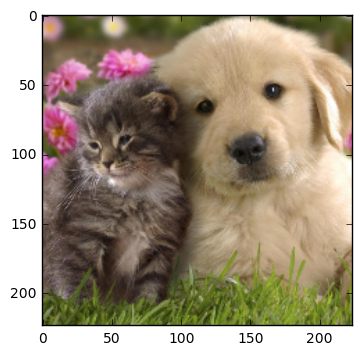

In [35]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [36]:
last_word_probas = get_output(predicted_probabilities,deterministic=True)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas)


def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption])).ravel()

        assert len(next_word_probs.shape) ==1

        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [37]:
for i in range(10):
    print ' '.join(generate_caption(img,t=5.)[1:-1])

a small baby is holding a small stuffed animal
a little girl holding a small dog in her hands
a small white cat is sitting in the grass
a small white and white cat is looking at the camera
a small furry animal with a long tag
a small white dog is looking at the camera
a little girl holding a small bird in her hands
a small white dog is looking at the camera
a small white cat is looking out of the window
a small white and white cat is eating some food


In [38]:
print ' '.join(generate_caption(img,t=5., sample=False)[1:-1])

a small white and white cat is looking at the camera


# Demo

In [48]:
img = plt.imread(osp.join(DATA_DIR, 'data/images/motorbike.jpg'))
img = preprocess(img)

In [50]:
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
print txt

a black and white photo of a motorcycle parked in a garage


In [39]:
import os

In [51]:
def visualize_captioning(file_path):
    img = plt.imread(file_path)
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
    plt.show()

## Fine cases

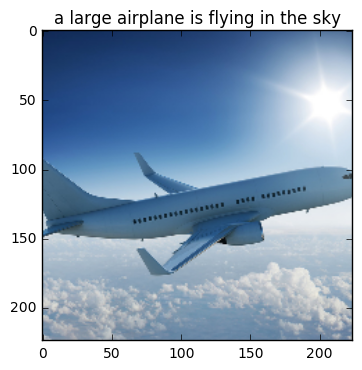

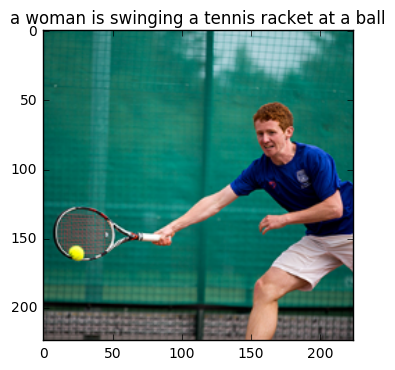

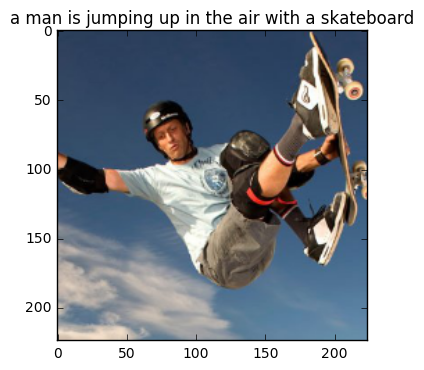

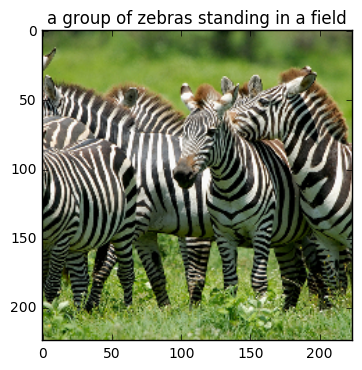

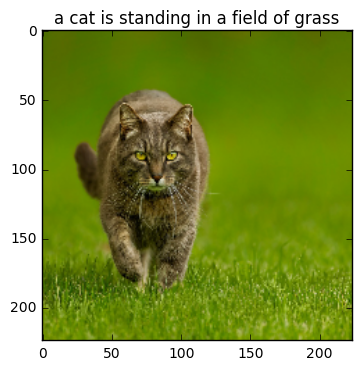

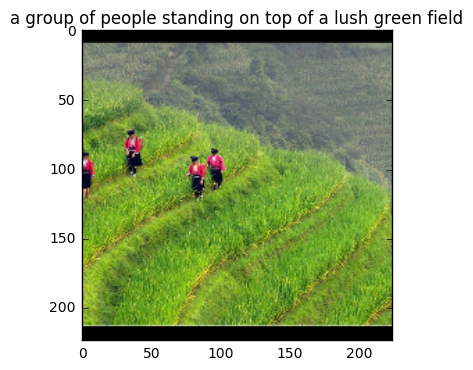

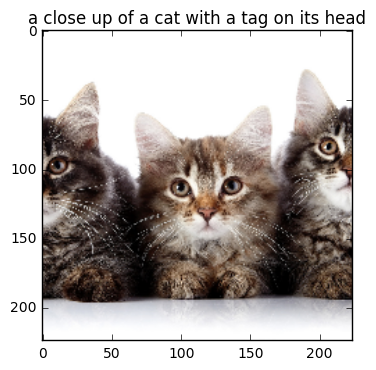

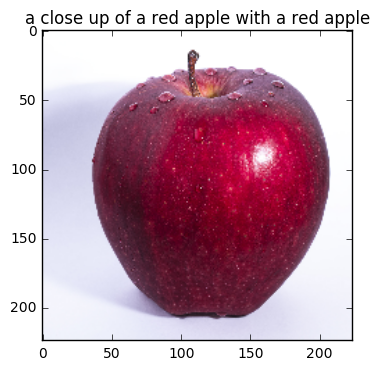

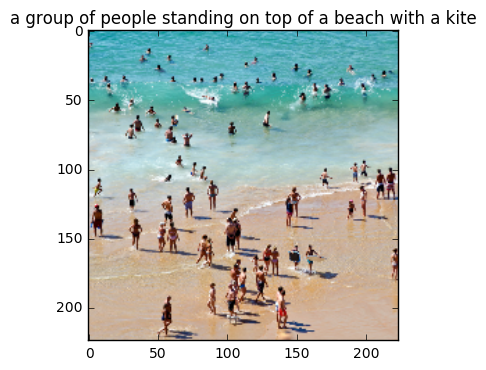

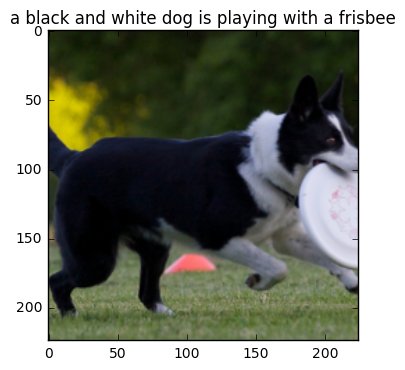

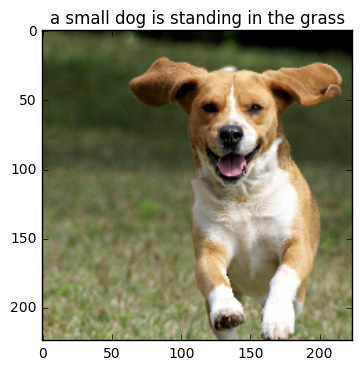

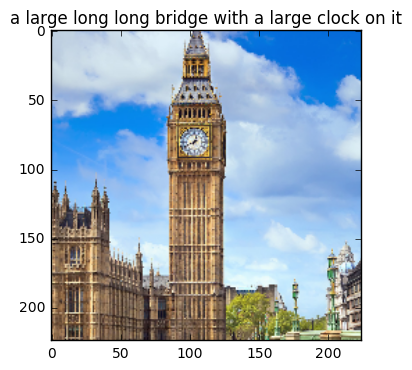

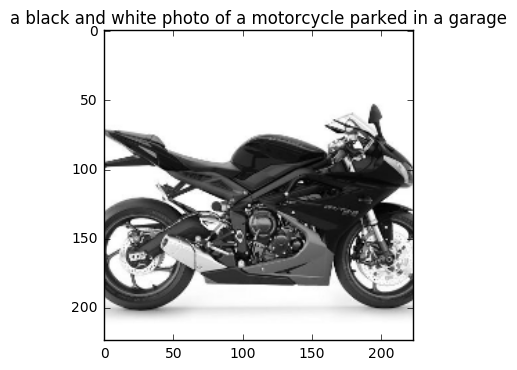

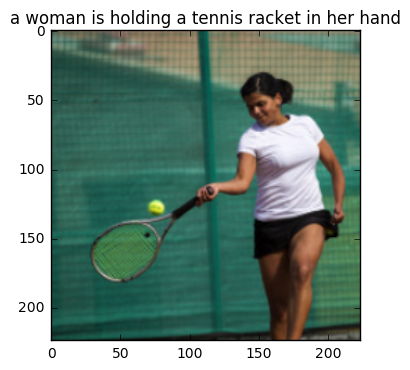

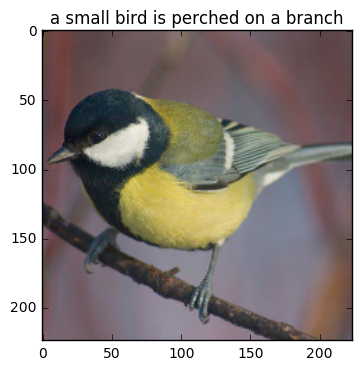

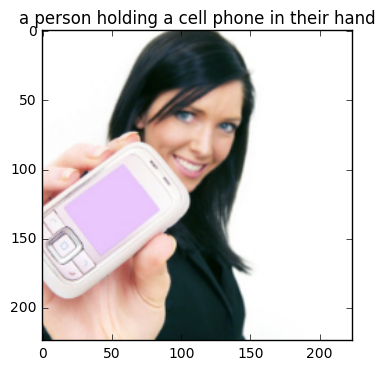

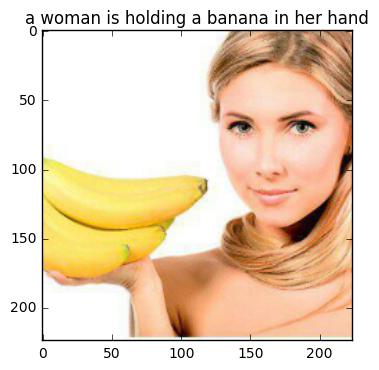

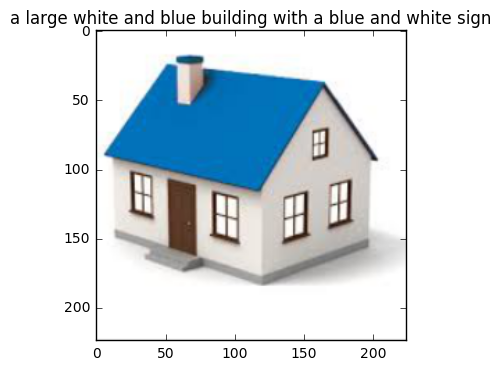

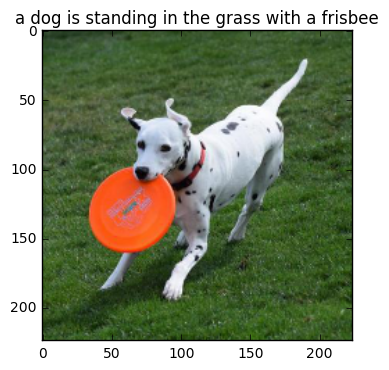

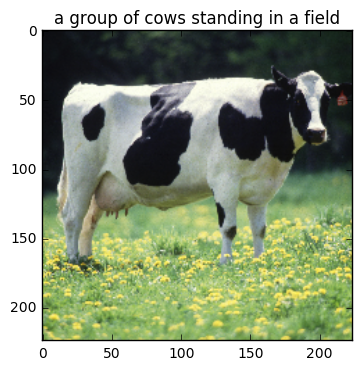

In [164]:
for filename in os.listdir('data/true_images/'):
    visualize_captioning('data/true_images/' + filename)

## Cases with significant mistakes

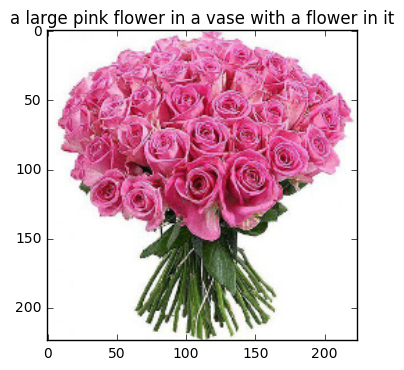

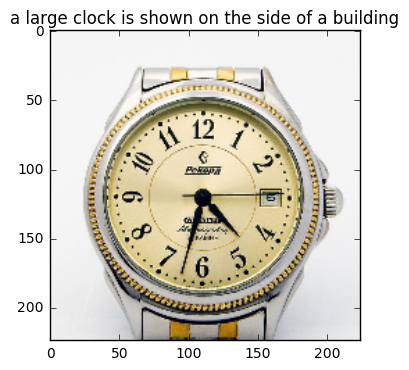

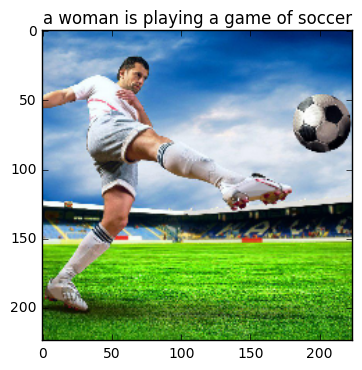

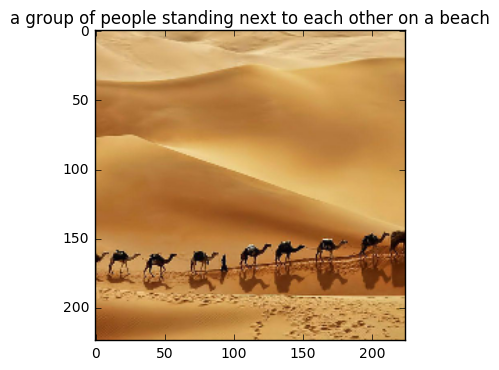

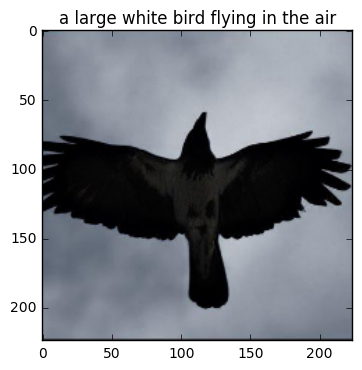

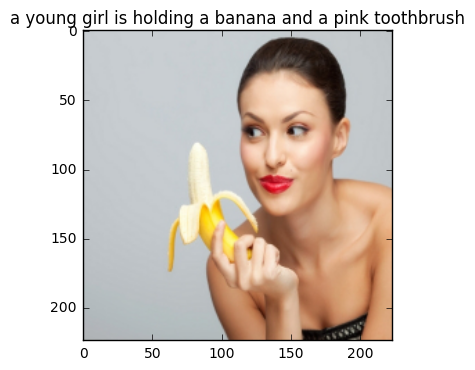

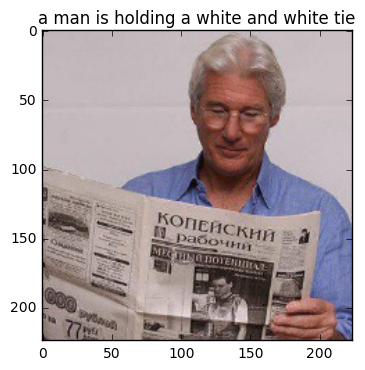

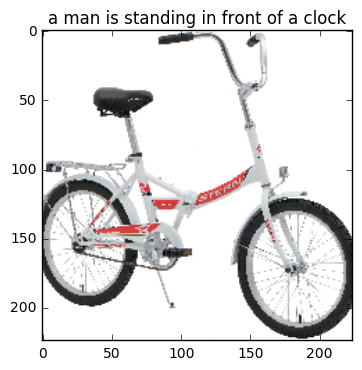

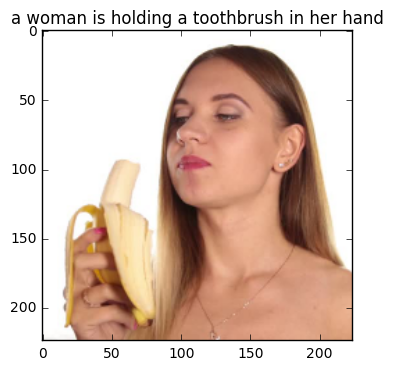

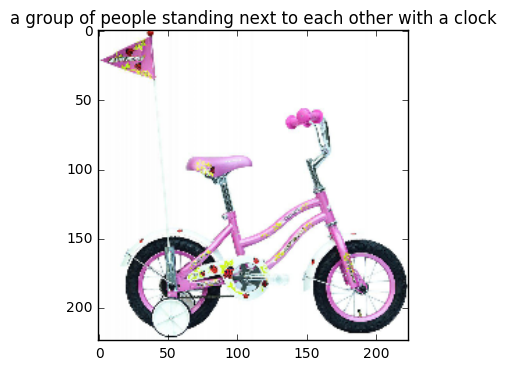

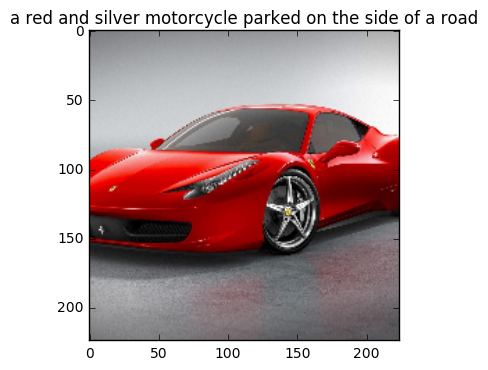

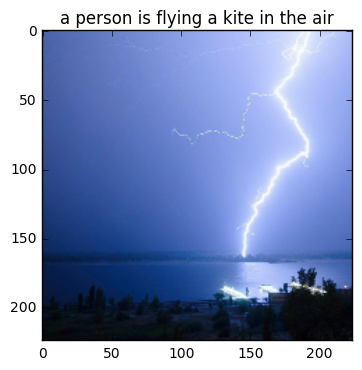

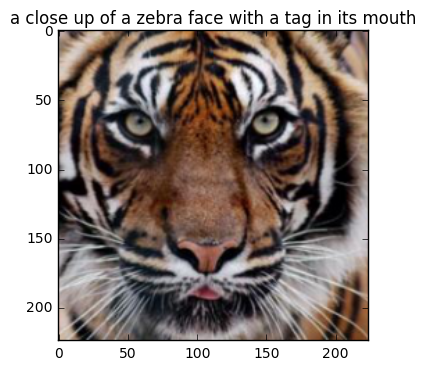

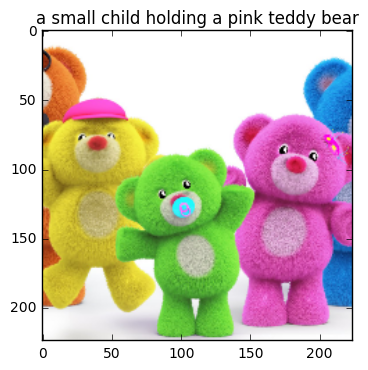

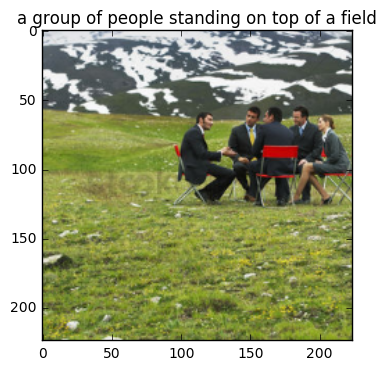

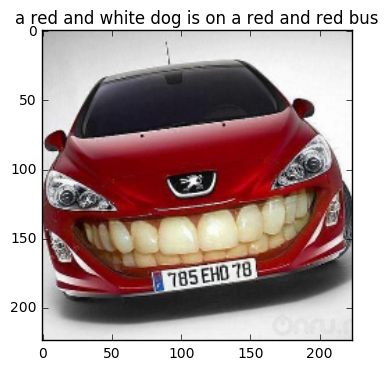

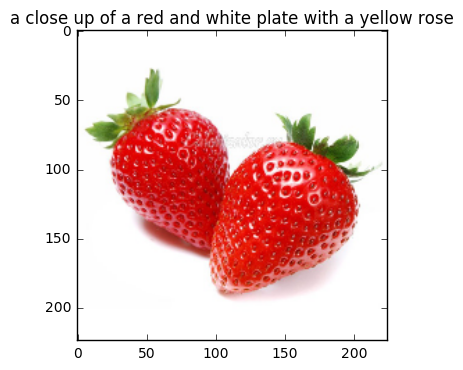

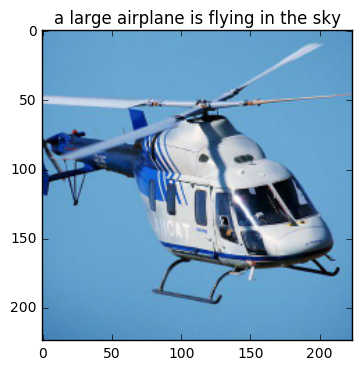

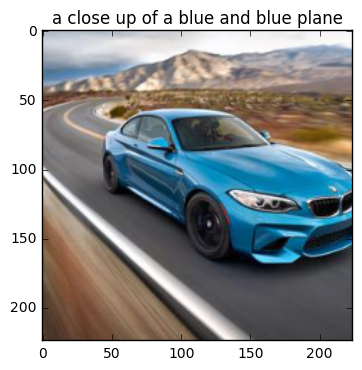

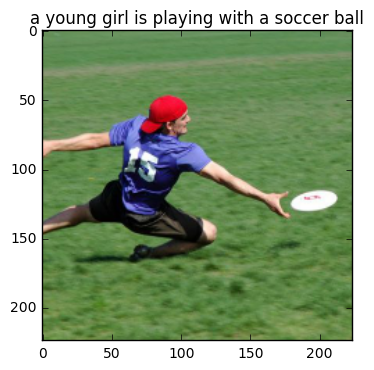

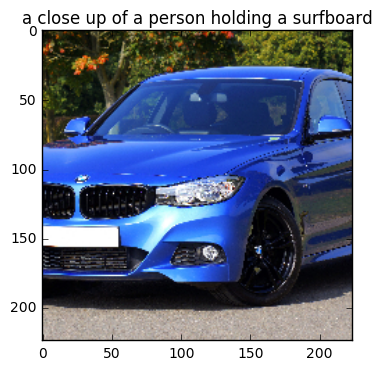

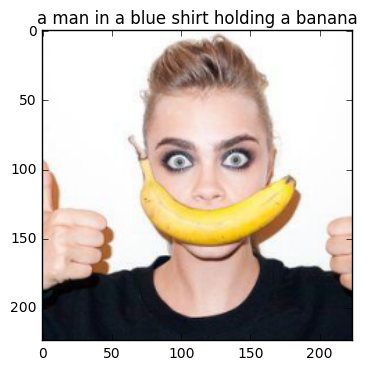

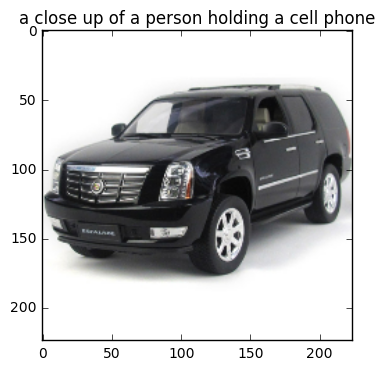

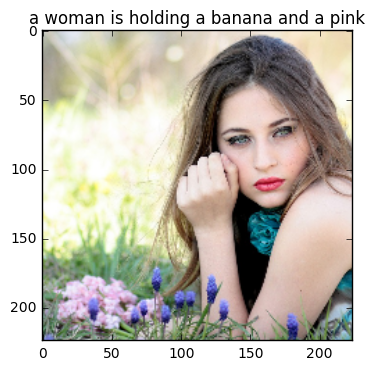

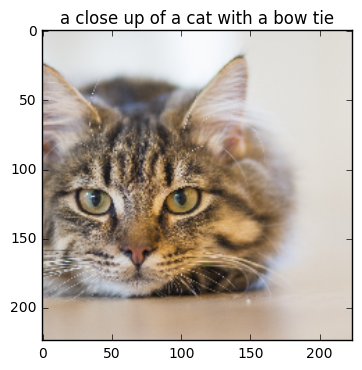

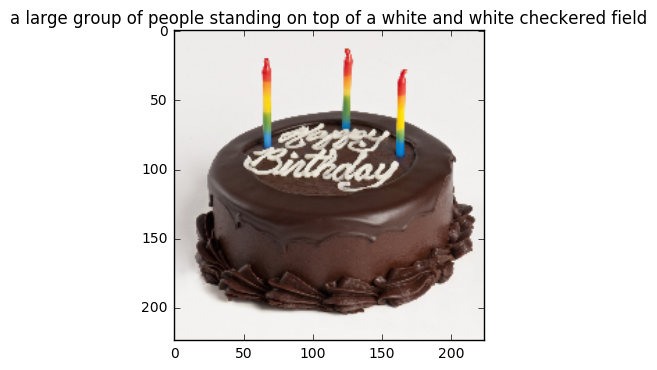

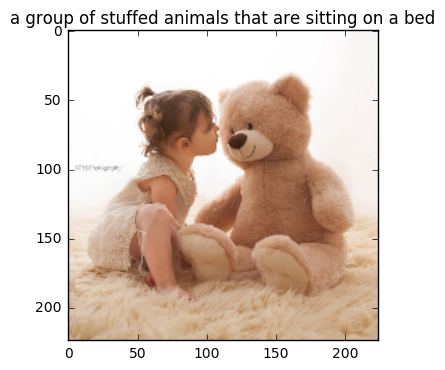

In [159]:
for filename in os.listdir('data/false_images/'):
    visualize_captioning('data/false_images/' + filename)